# Main Test Model
This code its the most recent and just has the necessary code to work

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import sys
from itertools import product
from lib.TechnicalIndicators import *
import random
from sklearn.linear_model import LinearRegression
from datetime import datetime

ModuleNotFoundError: No module named 'pandas'

In [2]:
class RNN():
    def __init__(self, data, model, scaler, scaler_obj, default_strategy = 1, weight = 1):
        self.columns_to_use = ['Close']
        self.data = data # Dataframe
        self.weight = weight #weight on the strategy (importance)
        self.default_strategy = default_strategy #strategy to use
        self.last_position = 0 #saves last position
        self.rnn = "rnn"
        # load the scaler and model
        self.sc = load(open(scaler, 'rb'))
        self.sc_obj = load(open(scaler, 'rb'))
        self.model = keras.models.load_model(model, compile=False)
        
    def calculate(self, force = False): #calculate for all dataframe
        if not self.rnn in self.data.columns or force:
            timestamps = self.model.layers[0].input_shape[1]
            #det data and scale
            inputs = self.data[self.columns_to_use].copy()
            inputs = self.sc.transform(inputs)
            #prepare input data as timeseries
            X = []
            for i in range(timestamps, len(inputs)+1):
                X.append(inputs[i-timestamps:i])
            X = np.array(X)
            predicted_position =np.concatenate(([np.nan]*(timestamps-1), self.model.predict(X, verbose = 0).flatten()))
            self.data[self.rnn] = self.sc_obj.inverse_transform(predicted_position.reshape(-1,1))
        #DONT DROP NA BECAUSE OTHER INDICATORS NEED THAT ROWS!!!
    def calculate_for_last_row(self): #calculate just for last row
        timestamps = self.model.layers[0].input_shape[1]
        inputs = self.data[-timestamps:].copy()[self.columns_to_use]
        inputs = self.sc.transform(inputs)
        X = np.array( [inputs] )
        predicted_position = self.model.predict(X, verbose = 0).flatten()
        self.data.loc[self.data.index[-1], self.rnn] = predicted_position[0]
        
    def strategy(self, row, num = -1):
        if num == -1: num = self.default_strategy #use default strategy 
        return self.strategy1(row)   
        
    def strategy1(self, row):
        '''Returns predicted position (1,0 or -1)'''
        if row == 0:
            self.last_position = 0
            return self.last_position, self.data[self.rnn][row]
        current_price = self.data["Close"][row]
        previous_prediction = self.data[self.rnn][row-1]
        current_prediction = self.data[self.rnn][row]
        diff = current_price - previous_prediction
        real_prediction = current_prediction + diff
        
        if real_prediction > current_price: 
            self.last_position = -1
        elif real_prediction < current_price: 
            self.last_position = 1
        else:
            self.last_position = 0
        return self.last_position, self.data[self.rnn][row]

In [3]:
class MaintenanceMarginTables():
    #obtained from https://www.binance.com/en/futures/trading-rules/perpetual/leverage-margin
    
    def __init__(self):
        ### Available Maintenance Margin tables ###
        self.BTCUSDT = None
        self.BTCBUSD = None
        ########### Fill each table ##############
        d = {'Tier': range(1,11),
         'PB' : [50000, 250000, 1000000, 10000000, 20000000, 50000000, 100000000, 200000000, 300000000, 500000000], #Position Bracker (Notional Value in USDT) (top boundary)
         'ML' : [125, 100, 50, 20, 10, 5, 4, 3, 2, 1], #Max Leverage
         'MMR' : [0.004, 0.005, 0.01, 0.025, 0.05, 0.1, 0.125, 0.15, 0.25, 0.5], #Maintenance Margin Rate
         'MA' : [0, 50, 1300, 16300, 266300, 1266300, 2516300, 5016300, 25016300, 100016300] #Maintenance AMount (USDT)
        }
        self.BTCUSDT = pd.DataFrame(data = d)

        d = {'Tier': range(1,11),
         'PB' : [50000, 250000, 1000000, 7500000, 40000000, 100000000, 200000000, 400000000, 600000000, 1000000000], #Position Bracker (Notional Value in BUSD) (top boundary)
         'ML' : [50, 25, 20, 10, 6, 5, 4, 3, 2, 1], #Max Leverage
         'MMR' : [0.004, 0.005, 0.01, 0.025, 0.05, 0.1, 0.125, 0.15, 0.25, 0.5], #Maintenance Margin Rate
         'MA' : [0, 50, 1300, 16300, 203800, 2203800, 4703800, 9703800, 49703800, 199703800] #Maintenance AMount (BUSD)
        }
        self.BTCBUSD = pd.DataFrame(data = d)
        
    def get_table(self, pair):
        table = "self."+ pair.upper()
        return eval(table)
MMT = MaintenanceMarginTables()  

#stores minimum order quantities
class MinOrders():
    
    def __init__(self):
        self.BTCBUSD = 0.001
        self.BTCUSDT = 0.001 #0.001 BTC
    def get_min_units(self, pair):
        return eval("self." + pair)
MO = MinOrders()
table = MMT.get_table("BTCUSDT")
table.loc[ 100 <= table['ML']].PB.iloc[-1]

250000

In [4]:
class Order():
    
    def __repr__(self):
        if self.position == 1:
            return "LONG"
        else:
            return "SHORT"
    
    def __init__(self, amount, leverage, expected_entry_price, position, created_at, 
                 fee_maker, fee_taker, use_fee, symbol, order_type = "MARKET", verbose = True):
        self.verbose = verbose
        self.symbol = symbol
        self.order_type = order_type
        self.amount = amount #desired size of position (leverage included)
        self.leverage = leverage
        self.expected_entry_price = expected_entry_price
        self.position = position #long (1) or short (-1)
        self.fee_maker = fee_maker #comision for limit order
        self.fee_taker= fee_taker #comision for market order
        self.use_fee = use_fee #True or False
        self.created_at = created_at # creating position datetime
        self.min_units = self.get_min_units()
        ########### Open position params ###########
        self.entry_price = None
        self.my_invest = None #amount to really spend from my balance
        self.opening_at = None #opening position datetime
        self.my_pos_amount = None #unlev amount to buy units (spent with no fee)
        self.my_pos_units = None #unit version of above attr
        self.pos_amount = None #position size (includes leverage)
        self.units = None #unit version of above attr
        self.opening_fee_as_amount = None 
        self.opening_fee_as_units = None
        self.blocks = 0 #stores the int number of times that min units can be bought
        self.available = 1 #currently all position is open
        ########### Close position params ###########
        self.closing_at = [] #close position datetime
        self.closing_fee_as_amount = [] 
        self.closing_fee_as_units = []
        self.closing_price = []
        self.liquidated = False #Tells if position was liquidated
        self.liquidation_price = None #stores the single liq price of order, if order is liquidated, to get real one, use closing_price[-1]
        
    def get_entry_price(self, low , high):
        if self.entry_price is not None:
            return self.entry_price
        #open price is a random number of current candle
        if self.order_type == "MARKET": 
            self.entry_price = np.random.uniform(low=low, high=high)
            #open price will be the expected...
        else:
            self.entry_price = self.expected_entry_price
        return self.entry_price
    
    def get_close_price(self, low, high, close, order_type = "MARKET"):
        if order_type == "MARKET": 
            close_price = np.random.uniform(low=low, high=high)
            #open price will be the expected...
        else:
            close_price = close
        return close_price
        
    def open_position(self, date, low, high):
        ##################### Works for long and short ################## 
        self.opening_at = date # open position datetime
        self.entry_price = self.get_entry_price(low, high)
        min_amount_with_fee = self.get_min_amount_to_spend(self.entry_price, include_fee = True, include_lev = False)
        self.blocks = self.amount // min_amount_with_fee #times min amount can be bought
        self.my_invest = self.get_min_amount_to_spend(self.entry_price, include_fee = True, include_lev = True) * self.blocks
        min_amount = self.get_min_amount_to_spend(self.entry_price, include_fee = False, include_lev = False)
        self.pos_amount = min_amount * self.blocks
        self.units = self.pos_amount / self.entry_price
        self.my_pos_amount = self.pos_amount / self.leverage
        self.my_pos_units = self.my_pos_amount / self.entry_price
        self.opening_fee_as_amount = (min_amount_with_fee - min_amount) * self.blocks
        self.opening_fee_as_units = self.opening_fee_as_amount/self.entry_price
        if self.blocks == 0: 
            print("Insufficient Margin to buy units")
            return False   
        if self.position == 1 and self.verbose:
            print("{} |  Buying {} for {}, leverage {}".format(self.opening_at, round(self.units, 5), round(self.entry_price, 4), self.leverage))
        elif self.verbose:
            print("{} |  Selling {} for {}, leverage {}".format(self.opening_at, round(self.units, 5), round(self.entry_price, 4), self.leverage))
        return True
        
    def get_close_fee(self, price, as_amount= True, prc = 100, use_available = True):
        #long - pay more comission if price raises
        #short - pay more comission if price falls
        if use_available:
            fraction = self.available * ( prc/100 )
        else: #if false, use all initial position budget
            fraction = ( prc/100 )
        fee = self.units * self.entry_price + self.position * self.units * (price - self.entry_price) 
        fee = fee * fraction * self.fee_taker #consider fee used and percentage of position to close
        if not as_amount: fee/=price #as units
        return fee * self.use_fee
    
    def get_PnL(self, price, include_fee = False, as_amount = True, prc = 100, use_available = True):
        #get profit (by default doesnt include fee as Binance)
        if use_available:
            fraction = self.available * ( prc/100 )
        else: #if false, use all initial position budget
            fraction = ( prc/100 )
        PnL = self.position * self.units * (price - self.entry_price) * fraction
        fee = self.get_close_fee(price, as_amount= True, prc = prc, use_available = use_available) * include_fee
        profit = PnL - fee
        if not as_amount: profit/=price
        return profit
    
    def get_current_amount(self, lev = True):
        if lev:
            return (self.pos_amount)*self.available
        else:
            return (self.my_pos_amount)*self.available
    
    def get_position_value(self, price, include_fee = True, as_amount = True, prc = 100, use_available = True):
        if use_available:
            fraction = self.available * ( prc/100 )
        else: #if false, use all initial position budget
            fraction = ( prc/100 )
        #gets the spent money and profits of the position (subtracts closing fee if True)
        profit = self.get_PnL(price = price, include_fee = include_fee, as_amount = True, prc = prc, use_available = use_available)
        pos_val = self.my_pos_amount * fraction  + profit
        if not as_amount: pos_val /= price
        return pos_val
    
    def close_position(self, date, price, prc = 100):
        fraction = self.available * (prc / 100)
        #if after closing with prc the remaining is less than min position, better close all now
        if self.units *(self.available - fraction) < self.min_units:
            prc = 100
            fraction = self.available
        #if closing is less than min units, close minimum units
        elif self.units * fraction < self.min_units:
            prc = (self.min_units / (self.units * self.available))*100
            fraction = self.available * (prc / 100)
        #close always a multiple of min units
        else:
            blocks_to_sell = round(self.blocks * fraction, 0)
            fraction = blocks_to_sell / self.blocks
            prc = fraction / self.available * 100 
        self.closing_at.append( date )
        self.closing_price.append( price )
        self.closing_fee_as_amount.append( self.get_close_fee(price, as_amount = True, prc = prc, use_available = True) )
        self.closing_fee_as_units.append( self.get_close_fee(price, as_amount = False, prc = prc, use_available = True) )
        pos_value = self.get_position_value(price, prc = prc, use_available = True)
        self.available = self.available - fraction #stores the position still opened
        partially = " partially" if self.is_open() else ""
        if self.position == -1 and self.verbose:
            print("{} |  Buying (closing{}) {} for {}".format(date, partially, self.units*fraction, round(price, 6)))
        elif self.verbose:
            print("{} |  Selling (closing{}) {} for {}".format(date, partially, self.units*fraction, round(price, 6)))  
        return pos_value
    
    def is_open(self):
        return abs(self.available) > 1e-12
    
    def is_closed(self):
        return not self.is_open()
    
    def get_maintenance_margin(self, price):
        #this is an example of how to retrieve a table and the necessary row with the information.
        if self.symbol.upper() in "BTCUSDT":
            table = MMT.get_table("BTCUSDT") 
        elif self.symbol.upper() in "BTCBUSD":
            table = MMT.get_table("BTCBUSD")
        else:
            table = MMT.get_table(self.symbol)
        size = self.units*price #size of position
        #locate the corresponding row with size
        row = table.loc[ size >= table['PB'].shift(1).fillna(0) ].loc[ size < table['PB'] ]
        #get all the row values, these are the required to calculate maintenance margin.
        tier, pb, ml, mmr, ma = row.values[0]
        mm = size * mmr - ma
        return mm
    
    def get_min_units(self):
        #get minimum units to buy (doesnt include fee)
        if self.symbol.upper() in "BTCUSDT":
            minimum = MO.get_min_units("BTCUSDT") 
        elif self.symbol.upper() in "BTCBUSD":
            minimum = MO.get_min_units("BTCBUSD")
        else:
            minimum = MO.get_min_units(self.symbol)
        return minimum
    
    def get_min_amount_to_spend(self, price, include_fee = True, include_lev = False):
        #this function returns the minimum amount to spend (includes fee).
        #get my invest in the position    
        pos_amount = self.min_units * price
        spent = pos_amount
        if include_lev: spent = pos_amount / self.leverage
        if not include_fee: return spent
        #include fees of position
        if self.order_type == "MARKET":
            spent += self.use_fee * self.fee_maker * pos_amount 
        else:
            spent += self.use_fee * self.fee_taker * pos_amount 
        return spent
    
    def calculate_margin_ratio(self, price):
        #when margin ratio == 1, that is the liquidation price
        maintenance_margin = self.get_maintenance_margin(price)
        balance = self.my_pos_amount #just for isolated mode (for cross you must use wallet)
        quantity = self.units
        mark_price = price #for simplicity
        entry_price = self.entry_price
        
        margin_ratio = maintenance_margin/( balance + self.position* quantity * ( mark_price - entry_price ))
        return margin_ratio
    
    def get_liquidation_price(self):
        #uses price instead of mark_price for simplicity
        #the liquidation price changes to farther when mark price gets close, so we  
        #execute this function many times to get close to the real one!!!!
        if self.liquidation_price is not None: return self.liquidation_price
        mark_price = self.entry_price
        pos = self.position
        entry_price = self.entry_price
        balance = self.my_pos_amount #just for isolated mode (for cross you must use wallet)
        quantity = self.units
        precision = 5 #more precision == closer you get to real liquidation price
        for i in range(precision):
            maintenance_margin = self.get_maintenance_margin(mark_price)
            liquidation_price = pos*( maintenance_margin - balance )/quantity + entry_price
            mark_price = liquidation_price
        self.liquidation_price = liquidation_price 
        return self.liquidation_price
    
    def should_liquidate(self, price): 
        if self.position == 1 and price <= self.get_liquidation_price():
            return True
        elif self.position == -1 and price >= self.get_liquidation_price():
            return True
        else:
            return False
    
    def liquidate_position(self, date, global_liquidation = None):
        liq_price = self.liquidation_price
        # if this is given, you have multiple orders and other liquidation price
        if global_liquidation != None:
            liq_price = global_liquidation
        self.closing_at.append( date )
        self.closing_price.append( liq_price )
        self.liquidated = True
        if self.position == -1 and self.verbose:
            print("{} |  Buying (liquidating) {} for {}".format(date, self.units*self.available, round(self.closing_price[-1], 5)))
        elif self.verbose:
            print("{} |  Selling (liquidating) {} for {}".format(date, self.units*self.available, round(self.closing_price[-1], 5))) 
        self.available = 0
        

In [5]:
class BinanceApi():

    def __init__(self, symbol, start, end, amount, use_fee = True, fee_maker=0, fee_taker=0,
                 verbose = True, csv = "data/5m.csv"):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.csv = csv #csv to use
        self.initial_balance = amount
        self.available_balance = amount #keeps unlevered balance (real balance)
        self.open_orders = [] #stores open orders
        self.closed_orders= [] #stores closed orders
        self.PnLs = []
        self.liquidated_orders = 0 #stores count of liquidated orders
        self.trades = 0
        self.paid_fees = 0 #accumulates paid fees
        self.use_fee = use_fee
        self.fee_maker = fee_maker #limit orders fee
        self.fee_taker = fee_taker #market orders fee (higher)
        self.leverage = 1
        self.get_data()
        self.verbose = verbose
        self.global_liquidation = None #stores liquidation price of all positions combined
    def get_data(self):
        raw = pd.read_csv(self.csv, parse_dates = ["Date"], index_col = "Date").dropna()
        raw = raw.loc[self.start:self.end]
        raw["returns"] = np.log(raw.Close / raw.Close.shift(1))
        raw["Hold Strategy"] = raw["returns"].cumsum().apply(np.exp) * self.initial_balance
        self.data = raw

    def plot_data(self, cols = None, show_pos = False):
        if not show_pos:
            if cols is None:
                cols = "Close"
            self.data[cols].plot(figsize = (12, 8), title = self.symbol)
        else:
            colors = ['green' if x==1 else ( "red" if x== -1 else "gray" ) for x in self.positions]
            plt.figure(figsize=(10,6))
            for i in range(1,len(self.data)):
                s = self.data.iloc[i-1:i+1]
                plt.plot(s.index, s[["NAV"]], c=colors[i-1], linewidth = 1)
            plt.plot(self.data.index, self.data[["Hold Strategy"]], c="cornflowerblue", linewidth=1)    
            plt.show()
    def get_values(self, bar):
        date = str(self.data.index[bar])
        close = round(self.data.Close.iloc[bar], 5)
        return date, close
    
    def get_value(self, bar, column):
        value = round(self.data[column].iloc[bar], 5)
        return value
    def print_available_balance(self, bar):
        date, price = self.get_values(bar)
        print("{} | Current Balance: {}".format(date, round(self.available_balance, 2)))
        
    def submit_order(self, bar, amount = None, pos = "BUY", order_type = "LIMIT"):
        #close positions if necessary
        if (self.get_position() in [-1] and pos == "BUY") or (self.get_position() in [1] and pos == "SELL"):
            close_amount = min(self.current_invested_amount(), amount)
            self.close_position(bar, close_amount, order_type = order_type)
            amount = amount - close_amount
        #open position...
        if abs(amount) > 1e-04:
            date, expected_entry_price = self.get_values(bar)
            
            order = Order(amount = amount, 
              leverage = self.leverage, 
              expected_entry_price = expected_entry_price,
              position = 1 if pos == "BUY" else -1, 
              created_at = date,       
              fee_maker = self.fee_maker, 
              fee_taker = self.fee_taker, 
              use_fee = self.use_fee,
              symbol = self.symbol,         
              verbose = self.verbose,
                         order_type = order_type)
            success = order.open_position(date = date,
                                         low = self.get_value(bar, "Low"),
                                         high = self.get_value(bar, "High"))
            if order.my_pos_amount > self.available_balance: #avoids floating errors
                self.not_enough_balance(order.my_pos_amount, self.available_balance)
            if not success:
                return  #dont continue with operation!
            self.paid_fees += order.opening_fee_as_amount
            self.open_orders.append(order)
            self.available_balance -= order.my_invest
            self.trades += 1
            self.calculate_global_liquidation() #calculate liquidation after opening order...
            
    def close_position(self, bar, amount, order_type = "LIMIT"):
        date, close = self.get_values(bar)
        prc = min(amount/self.current_invested_amount()*100, 100) #max sell everything
        should_remove = []
        #remove same percentage of all open orders
        for idx, order in enumerate(self.open_orders):
            close_price = order.get_close_price(order_type = order_type, 
                            low = self.get_value(bar, "Low"), 
                            high = self.get_value(bar, "High"), 
                            close = close)  
            self.PnLs.append(order.get_PnL(price = close_price, include_fee = True, prc = prc) - order.opening_fee_as_amount*order.available*(prc/100))
            pos_value = order.close_position(date = date, price = close_price, prc = prc)
            self.paid_fees += order.closing_fee_as_amount[-1]
            self.available_balance += pos_value
            if order.is_closed():
                should_remove.append(idx)
    
        #remove closed orders
        for idx in sorted(should_remove, reverse = True):
            order = self.open_orders[idx]
            self.closed_orders.append(order)
            self.open_orders.pop(idx)
        if len(self.open_orders) == 0:
            self.global_liquidation = None #no position opened
    
    def calculate_global_liquidation(self):
        if len(self.open_orders) == 0:
            self.global_liquidation = None
            return
        if len(self.open_orders) == 1:
            self.global_liquidation = self.open_orders[0].get_liquidation_price() 
            return
        #more than 1 order
        global_liq = self.open_orders[-1].entry_price #init global liquidation 
        pos = self.open_orders[0].position #get position
        i = 512
        while i >= 0.4:
            available_amount = sum(order.get_current_amount(lev = False) for order in self.open_orders)
            new_gl = global_liq - i * pos #test the new liquidation price
            for order in self.open_orders:
                #order inside margin available
                if (pos == 1 and new_gl > order.get_liquidation_price() ) or (pos == -1 and new_gl < order.get_liquidation_price() ):
                    available_amount += order.get_PnL(price = new_gl, as_amount = True, include_fee = True)
                #order liquidated by itself
                else:
                    available_amount -= order.get_current_amount(lev = False) #remove margin
                    extra_loss = order.entry_price - (order.get_liquidation_price() - new_gl) 
                    available_amount += order.get_PnL(price = extra_loss, as_amount = True, include_fee = True) #remove extra losses
            if available_amount >= 0:
                global_liq = new_gl
            else:
                i/=2
        #this is an approximation...
        self.global_liquidation = global_liq
    def current_invested_amount(self, lev = True):
        invested = 0
        for order in self.open_orders:
            invested += order.get_current_amount(lev = lev)
        return invested
    
    def get_min_amount_to_invest(self, bar, leverage = 1,just_margin = True):    
        price = self.get_value(bar, "High") #use highest value of candle for max amount   
        order = Order(amount = 0, 
              leverage = leverage, 
              expected_entry_price = price,
              position = 1, #1 for long, -1 for short
              created_at = datetime.now(), #datetime when order is created        
              fee_maker = self.fee_maker, 
              fee_taker = self.fee_taker, 
              use_fee = self.use_fee,
              symbol = self.symbol,
             order_type = "LIMIT") #use limit to pay max fees
        min_amount = order.get_min_amount_to_spend(price, include_fee=True, include_lev = True)
        return min_amount + 1e-08
            
    def print_current_nav(self, bar):
        nav = self.get_nav(bar)
        print("{} |  Net Asset Value = {}".format(date, round(nav, 2)))
        
    def get_nav(self, bar):
        if len(self.open_orders) == 0: return self.available_balance
        date, price = self.get_values(bar)
        pos_value = 0
        for order in self.open_orders:    
            pos_value += order.get_position_value(price = price, include_fee = True, as_amount = True)
        return self.available_balance + pos_value

    def get_position(self):
        if len(self.open_orders) == 0:
            return 0
        return self.open_orders[0].position
    
    def verify_not_liquidation(self, bar):
        if self.get_position() == 0: return #currently no open positions
        low = self.get_value(bar, "Low")
        high = self.get_value(bar, "High")
        #global liquidation is calculated when a new position is opened
        if (self.get_position() == 1 and low <= self.global_liquidation) or (self.get_position() == -1 and high >= self.global_liquidation):
            self.liquidate_all(bar)
            return True
        else:
            return False
        
    def liquidate_all(self, bar):
        date, price = self.get_values(bar)
        for order in self.open_orders:
            #liquidate at global liquidation
            order.liquidate_position(date = date, global_liquidation = self.global_liquidation)
            self.closed_orders.append(order)
            self.PnLs.append(-order.my_pos_amount-order.opening_fee_as_amount*order.available)
        self.liquidated_orders += len(self.open_orders)
        self.open_orders = []
    
    def not_enough_balance(self,need, have):
        print("You dont have necessary balance to open this order!: cost:{}, balance:{}".format(
                    round(need,2), round(have,2)
                ))
    def get_max_order_leverage(self, total_amount):
        if self.symbol.upper() in "BTCUSDT":
            table = MMT.get_table("BTCUSDT") 
        elif self.symbol.upper() in "BTCBUSD":
            table = MMT.get_table("BTCBUSD")
        else:
            table = MMT.get_table(self.symbol)
        max_leverage = table.loc[ total_amount <= table['PB']].ML.iloc[0]
        return max_leverage
    def get_max_order_amount(self, leverage):
        if self.symbol.upper() in "BTCUSDT":
            table = MMT.get_table("BTCUSDT") 
        elif self.symbol.upper() in "BTCBUSD":
            table = MMT.get_table("BTCBUSD")
        else:
            table = MMT.get_table(self.symbol)
        max_total_amount = table.loc[ leverage <= table['ML']].PB.iloc[-1]
        
        return max_total_amount + max_total_amount * self.use_fee * self.fee_taker
        
        return max_total_amount
    def validate_order_amount(self, desired_amount, leverage, bar):
        #returns a valid amount to spend with a certain leverage
        #### MAXIMUM ####
        max_amount_with_lev = self.get_max_order_amount(leverage)
        max_amount_with_balance = self.available_balance*self.leverage
        amount = min(max_amount_with_lev, max_amount_with_balance, desired_amount) #respect leverage and balance restrictions!!
        ####MINIMUM####
        min_amount_to_invest = self.get_min_amount_to_invest(bar, leverage = leverage,just_margin = False)
        amount = max(min_amount_to_invest, amount)
        ##############
        if amount > self.available_balance * leverage:
            return False
        if self.verbose and not abs(desired_amount - amount) < 1e-3: #numbers are distinct 
            print("Invalid amount ({}) for order, changing to a valid one... ({})".format(round(desired_amount,2),  round(amount,2)  )  )
        return amount
    def change_leverage(self, new_lev):
        #current_position = self.get_position()
        min_lev = self.get_min_leverage()
        if new_lev < min_lev:
            print("Cant change leverage to {}, current is {} with open position".format(new_lev, min_lev))
            return -1
        self.leverage = new_lev
        return self.leverage
    
    def get_min_leverage(self):
        #returns the max leverage of the orders, that is the minimum leverage we can use
        if len(self.open_orders) == 0:
            return 1
        lev = 1
        for order in self.open_orders:
            lev = max(order.leverage, lev)
        return lev    

In [6]:
class IterativeBacktest(BinanceApi):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.strategies = [] #keeps all the strategies used
        self.predicted_pos = 0 #keeps current predicted position of strategies
        self.ind_sum = 0 #keeps current indicators sum for predicted positions
        self.weights_sum = 0 #keeps weight sum of strategies to use it with leverage
        self.obv = None #stores OBV used to filter trades
        self.lower_bound = 0.001 #Used for rnn strategy and leverage
        self.upper_bound = 0.01

    # helper method
    def go_long(self, bar, amount = None, prc = False, go_neutral_first = False):
        if self.get_position() != 0 and go_neutral_first:
            self.go_neutral(bar) #if some position, go neutral first
        #self.leverage_strategy(min_x = self.lower_bound, max_x = self.upper_bound)
        if amount == "all":
            amount = self.available_balance * self.leverage
        elif prc: 
            amount = (self.available_balance * amount/100) * self.leverage    
        amount = self.validate_order_amount(amount, self.leverage, bar)
        if amount:
            self.submit_order(bar, amount = amount, pos = "BUY")

    # helper method
    def go_short(self, bar, amount = None, prc = False, go_neutral_first = False):
        if self.get_position() != 0 and go_neutral_first:
            self.go_neutral(bar) #if some position, go neutral first
        #self.leverage_strategy(min_x = self.lower_bound, max_x = self.upper_bound)
        if amount == "all":
            amount = self.available_balance * self.leverage
        elif prc: 
            amount = (self.available_balance * amount/100) * self.leverage    
        amount = self.validate_order_amount(amount, self.leverage, bar)
        if amount:
            self.submit_order(bar, amount = amount, pos = "SELL")
    
    def go_neutral(self, bar, prc = 100):
        if self.get_position() == 1: #if long, sell all
            self.submit_order(bar, amount = self.current_invested_amount()*prc/100, pos = "SELL")
        elif self.get_position() == -1: #if short, buy all
            self.submit_order(bar, amount = self.current_invested_amount()*prc/100, pos = "BUY")
            
    def calculate_metrics(self, bar):
        if not self.keep_metrics: return
        self.positions.append( self.get_position() )
        self.navs.append( self.get_nav(bar) )
        
    def add_metrics_to_data(self):
        if not self.keep_metrics: return
        self.positions = self.positions + [0]*( self.data.shape[0] - len(self.positions) )
        self.navs = self.navs + [ self.navs[-1] ]*( self.data.shape[0] - len(self.navs) )
        self.data["Position"] = self.positions
        self.data["NAV"] = self.navs
        
    def close_final_position(self, bar):
        date, price = self.get_values(bar)
        self.go_neutral(bar) # if some position, go neutral
        perf = (self.available_balance - self.initial_balance) / self.initial_balance * 100
        good_trades = 0
        bad_trades = 0
        good_trades_prc = 0
        bad_trades_prc = 0
        if self.trades > 0 :
            good_trades = np.sum(np.array(self.PnLs) > 0, axis = 0)
            good_trades_prc = round(good_trades / len(self.PnLs) *100,1)
            bad_trades = np.sum(np.array(self.PnLs) <= 0, axis = 0)
            bad_trades_prc = round(bad_trades / len(self.PnLs) *100,1)
            
        if self.verbose:
            self.print_available_balance(bar)
            print(75 * "-")
            print("+++ CLOSING FINAL POSITION +++")
            print("net performance (%) = {}".format( round(perf, 2) ))
            print("number of positions opened = {}".format(self.trades)) 
            print("number of liquidated orders = {}".format(self.liquidated_orders))
            print("number of good PnL = {} ({}%)".format(good_trades, good_trades_prc))
            print("number of bad PnL = {} ({}%)".format(bad_trades, bad_trades_prc))
            print("Amount spent on fee = {} ({}% of initial balance)".format(
                self.paid_fees, round(self.paid_fees/self.initial_balance*100, 2))
             ) 
            print(75 * "-")    
    
    def should_end_session(self, bar):
        min_amount_to_invest = self.get_min_amount_to_invest(bar, leverage = self.leverage,just_margin = True)
        #no money and no positions
        if self.available_balance < min_amount_to_invest and self.get_position() == 0:
            if self.verbose:
                print("Not enough money to trade! Ending trading session.")
            return True
        return False
        
    def optimize_parameters(self, number_of_tests = 4):
        ''' Finds an optimal strategy given random weights.'''
        
        test_weights = np.random.random_sample(size = (number_of_tests, 10))*0.6
        
        # test all combinations
        results = []
        for weights in test_weights:
            results.append(self.test_strategy(
                keep_metrics = False, #False makes the process faster
                verbose = False, #dont print order stuff
                weights = weights
            ))
        
        best_perf = np.max(results) # best performance
        opt_weights = test_weights[np.argmax(results)] # optimal parameters
        
        # run/set the optimal strategy
        self.test_strategy(
                keep_metrics = True, #False makes the process faster
                verbose = True, #dont print order stuff
                weights = opt_weights
            )
                   
        # create a df with many results
        #many_results =  pd.DataFrame(data = combinations, columns = ["SMA_S", "SMA_L"])
        #many_results["performance"] = results
        #self.results_overview = many_results
                            
        return opt_weights, best_perf  
    
    def optimize_parameters2(self, dropout = 4, iterations = 10, initial_weights = None):
        ''' Finds an optimal strategy given random weights.'''
        if initial_weights == None: initial_weights = np.random.random_sample(size = 10)*2 - 1    
        best_weights = initial_weights
        best_perf = self.test_strategy(
                        keep_metrics = False, #False makes the process faster
                        verbose = False, #dont print order stuff
                        weights = initial_weights
                    )
        print("Initial weights")
        print(initial_weights)
        best_perf_per = (best_perf - self.initial_balance) / self.initial_balance * 100
        print(str(round(best_perf_per,2)) + "%" )
        for i in range(iterations):
            if (i+1)%50 == 0: print ("Iteration " + str(i+1))
            new_weights = best_weights.copy()
            #replace some weights from best weights
            pos_to_change = random.sample(range(0, 10), dropout)
            drop_weights = np.random.random_sample(size = dropout)*2 -1 #between -1 and 1
            for pos, dp in zip(pos_to_change, drop_weights):
                new_weights[pos] = dp
            if best_perf > 0 and i%5 == 0:
                #multiply all weights by a scale, this helps to prevent lots of trades and optimize decisions
                scaler = np.random.normal(loc = 1, scale = 0.15) #normal distribution centered in 1
                new_weights = [scaler*x for x in new_weights]
            #evaluate
            perf = self.test_strategy(
                        keep_metrics = False, #False makes the process faster
                        verbose = False, #dont print order stuff
                        weights = new_weights
                    )
            if perf > best_perf and round(perf,1) != round(self.initial_balance,1):
                best_perf = perf
                best_weights = new_weights
                print("Found better...")
                print(new_weights)
                perf_per = (perf - self.initial_balance) / self.initial_balance * 100
                print(str(round(perf_per,2)) + "%")
        best_perf = self.test_strategy(
                        keep_metrics = True, #False makes the process faster
                        verbose = True, #dont print order stuff
                        weights = best_weights
                    )        
        return best_weights, best_perf  
    
    def test_strategy(self,keep_metrics = True, verbose = True, leverage = 1,weights = [1]*10,
                     amount_prc = 100, strategies=None):
        self.verbose = verbose 
        if self.verbose:
            stm = "Testing strategy | {}".format(self.symbol)
            print("-" * 75)
            print(stm)
            print("-" * 75)
        self.reset_params()
        self.change_leverage(leverage)
        # prepare params
        #SMA
        SMA_S = 5
        SMA_L = 8
        #EWMA
        #approx_avg_period_s = 5
        #approx_avg_period_l = 8
        #BBS
        dev = 1.5
        periods = 14
        #prepare strategies
        self.strategies = [
        #    SMA(
        #        data = self.data,
        #        SMA_S = SMA_S,
        #        SMA_L = SMA_L,
        #        column = "Close",
        #        default_strategy = 1,
        #        weight = weights[0]
        #    ),
        #    EWMA(
        #        data = self.data,
        #        approx_avg_period_s = approx_avg_period_s,
        #        approx_avg_period_l = approx_avg_period_l,
        #        column = "Close",
        #        default_strategy = 1,
        #        weight = weights[1]
        #    ),
            BollingerBands(
                data = self.data,
                dev = dev, 
                periods = periods,
                column = "Close",
                default_strategy = 1,
                weight = weights[2]
            ),
        #    MACD(
        #        data = self.data,
        #        fast =12,
        #        slow =26, 
        #        signal = 9,
        #        column = "Close",
        #        default_strategy = 1,
        #        weight = weights[3]
        #    ),
        #    RSI(
        #        data = self.data,
        #        length = 14,
        #        column = "Close",
        #        default_strategy = 1,
        #        weight = weights[4]
        #    ),
        #    Hammer(
        #        data = self.data,
        #        default_strategy = 1,
        #        weight = weights[5]
        #    ),
        #    Doji(
        #        data = self.data,
        #        default_strategy = 1,
        #        weight = weights[6]
        #    ),
        #    EBSW(
        #        data = self.data,
        #        default_strategy = 1,
        #        column = "Close",
        #        weight = weights[7]
        #    ),
        #    ADX(
        #        data = self.data,
        #        default_strategy = 1,
        #        weight = weights[8],
        #    ),
        #    KVO(
        #        data = self.data,
        #        default_strategy = 1,
        #        weight = weights[9],
        #    ),
        #    OBV(
        #        data = self.data
        #    )
        ]
        self.strategies = strategies
        for strategy in self.strategies:
            strategy.calculate() #add columns to data   
        self.data.dropna(inplace = True) #dropna after calculating the strategy
        #prepare metrics
        self.keep_metrics = keep_metrics
        self.positions, self.navs = [], []
 
        for bar in range(len(self.data)-1): # all bars (except the last bar)
            #date, price = self.get_values(bar) #useful to get current date and price
            self.verify_not_liquidation(bar) #verify current order isnt liquidated
            if self.should_end_session(bar): break #check if should end session  
            ############### Algorithm ############### 
            self.ind_sum = 0
            for strategy in self.strategies:
                self.ind_sum += strategy.strategy(bar) * strategy.weight
            self.predicted_pos = np.sign(self.ind_sum) 
            #self.predicted_pos, self.ind_sum = self.rnn.strategy(bar, bound = self.lower_bound)    
            #if abs(self.ind_sum) < 0.5: self.ind_sum = 0 #discards weak signals < |0.5|    
            if self.predicted_pos == 1 and self.get_position() in [0, -1]:
                self.go_long(bar, amount = amount_prc, prc=True, go_neutral_first = True)
            if self.predicted_pos == -1 and self.get_position() in [0, 1]:
                self.go_short(bar, amount = amount_prc, prc=True, go_neutral_first = True)
                
            ############## End Algorithm ############        
            self.calculate_metrics(bar)
        
        self.verify_not_liquidation(bar+1)           
        self.close_final_position(bar+1) # close the final open position
        self.calculate_metrics(bar+1)
        self.add_metrics_to_data()
        return round(self.available_balance, 2)
    
    def test_rnn_strategy(self,keep_metrics = True, verbose = True, leverage = 1,
                         amount_prc = 100, wait_interval = 7):
        self.verbose = verbose 
        if self.verbose:
            stm = "Testing strategy | {}".format(self.symbol)
            print("-" * 75)
            print(stm)
            print("-" * 75)
        self.reset_params()
        self.change_leverage(leverage)
        self.rnn = RNN(
            data = self.data,
            default_strategy = 1,
            model = 'models_work/simple_current.h5',
            scaler = 'models_work/scaler.pkl',
            scaler_obj = 'models_work/scaler_obj.pkl'
        )
        self.rnn.calculate()    
        self.data.dropna(inplace = True) #dropna after calculating the strategy
        #prepare metrics
        self.keep_metrics = keep_metrics
        self.positions, self.navs = [], []
        wait = 0
        for bar in range(len(self.data)-1): # all bars (except the last bar)
            #date, price = self.get_values(bar) #useful to get current date and price
            self.verify_not_liquidation(bar) #verify current order isnt liquidated
            if self.should_end_session(bar): break #check if should end session  
            if wait > 0:
                self.calculate_metrics(bar)
                wait-=1
                continue
            ############### Algorithm ############### 
            self.predicted_pos, self.ind_sum = self.rnn.strategy(bar)
            if self.predicted_pos == 1 and self.get_position() in [0]:
                self.go_long(bar, amount = amount_prc, prc=True, go_neutral_first = True)
                
            elif self.predicted_pos == 1 and self.get_position() in [-1]:
                self.go_neutral(bar)
                if self.PnLs[-1] < 0:
                    wait = wait_interval
                    #self.change_leverage(max(1, int(self.leverage/2)))
                    if wait > 0: continue
                else:
                    pass
                    #self.change_leverage(min(leverage, self.leverage*2))
                self.go_long(bar, amount = amount_prc, prc=True, go_neutral_first = True)
                
            elif self.predicted_pos == -1 and self.get_position() in [0]:
                self.go_short(bar, amount = amount_prc, prc=True, go_neutral_first = True)
                
            elif self.predicted_pos == -1 and self.get_position() in [1]:
                self.go_neutral(bar)
                if self.PnLs[-1] < 0:
                    wait = wait_interval
                    #self.change_leverage(max(1, int(self.leverage/2)))
                    if wait > 0: continue
                else:
                    pass
                   # self.change_leverage(min(10, self.leverage*2))
                self.go_short(bar, amount = amount_prc, prc=True, go_neutral_first = True)
                

            ############## End Algorithm ############        
            self.calculate_metrics(bar)
        
        self.verify_not_liquidation(bar+1)           
        self.close_final_position(bar+1) # close the final open position
        self.calculate_metrics(bar+1)
        self.add_metrics_to_data()
        return round(self.available_balance, 2)
    
    def leverage_strategy(self, min_x, max_x, min_y = 1, max_y = 15):
        if max_y < min_y:
            print("max leverage is less than min leverage")
            return -1
        #y = y1 + m(x-x1) , m =(y2-y1)/(x2-x1)
        #two points of the line: (min_x, min_y) and (max_x, max_y)
        x = min(max_x, abs(self.ind_sum)) #short or long, we want just abs number
        m = (max_y-min_y)/(max_x-min_x)
        new_leverage = round( min_y + m*( x - min_x ))
        new_leverage = max(self.get_min_leverage(), new_leverage ) #open orders restrictions
        self.change_leverage(new_leverage)
        return new_leverage
    
    def calculate_weights_sum(self):
        self.weights_sum = 0
        for strategy in self.strategies:
            self.weights_sum += abs(strategy.weight)  
        return self.weights_sum
    
    def reset_params(self):
        # reset 
        self.trades = 0  # no trades yet
        self.available_balance = self.initial_balance  # reset initial capital
        self.get_data() # reset dataset
        self.open_orders = []
        self.closed_orders = []
        self.paid_fees = 0
        self.liquidated_orders = 0
        self.PnLs = []
        self.strategies = []
        #useful for replicating results...
        #EXAMPLE: market orders take a random number to execute so its more chaotic
        np.random.seed(1)
    
    
    def test_grid_strategy(self,keep_metrics = True, verbose = True, 
                           initial_lev = 1, initial_amount = 20, prc = False,
                           devs = [1.5], periods = [100], min_std_size = None,
                          min_std_use_prc = False,
                          bbs_go_neutral_prc = 100):
        self.verbose = verbose 
        if self.verbose:
            stm = "Testing strategy | {}".format(self.symbol)
            print("-" * 75)
            print(stm)
            print("-" * 75)
        self.reset_params()
        #same period to each dev if just one period given
        if len(periods) == 1:
            periods = periods * len(devs)
        #prepare strategies
        for dev, period in zip(devs,periods):
            self.strategies.append(
                BollingerBands(
                    data = self.data,
                    dev = dev, 
                    periods = period,
                    column = "Close",
                    default_strategy = 1,
                    min_std_size = min_std_size,
                    min_std_use_prc_of_sma_mean = min_std_use_prc
                )
            )    
        for strategy in self.strategies:
            strategy.calculate() #add columns to data    
        self.data.dropna(inplace = True) #dropna after calculating the strategy
        #prepare metrics
        self.keep_metrics = keep_metrics
        self.positions, self.navs = [], []
        self.curr_lvl = 0
        self.change_leverage(initial_lev)
        curr_amount = initial_amount
        for bar in range(len(self.data)-1): # all bars (except the last bar)
            #date, price = self.get_values(bar) #useful to get current date and price
            self.verify_not_liquidation(bar) #verify current order isnt liquidated
            if self.should_end_session(bar): break #check if should end session  
            ############### Algorithm ############### 
            self.pred_lvl = 0
            for strategy in self.strategies:
                self.pred_lvl += strategy.strategy(bar)
            self.predicted_pos = np.sign(self.pred_lvl)
            #is neutral or suddently changes betweeen long and short
            if self.predicted_pos == 0 or (self.curr_lvl != 0 and np.sign(self.pred_lvl) != np.sign(self.curr_lvl)):
                self.go_neutral(bar, prc = 100)
                self.change_leverage(initial_lev)
                self.curr_lvl = 0
                curr_amount = initial_amount
            
            elif abs(self.pred_lvl) > abs(self.curr_lvl):
                if self.predicted_pos == 1:
                    self.go_long(bar, amount = curr_amount, prc=prc, go_neutral_first = False)
                else:
                    self.go_short(bar, amount = curr_amount, prc=prc, go_neutral_first = False)
                self.curr_lvl = self.pred_lvl
                self.change_leverage(min(self.leverage*2, 125))
                #curr_amount *= 1
            ############## End Algorithm ############        
            self.calculate_metrics(bar)
        
        self.verify_not_liquidation(bar+1)           
        self.close_final_position(bar+1) # close the final open position
        self.calculate_metrics(bar+1)
        self.add_metrics_to_data()
        return round(self.available_balance, 2)

# Test strategies

In [6]:
bc = IterativeBacktest(
    symbol = "BTCUSD", 
    start = "2022-09-11", 
    end = "2022-09-12", #take care of the length of period!! It will help to make tests faster 
    amount = 25, #Less amount means make tests faster
    use_fee= True,
    fee_maker = 0.0002,
    fee_taker = 0.0004,
    csv = "data/btc-usdt_1m.csv"
)

In [34]:
bc = IterativeBacktest(
    symbol = "BTCUSD", 
    #start of file at 2022-12-01 09:02
    #end of file at 2022-12-08 07:41
    start = "2022-12-01 09:02", 
    end = "2022-12-07 9:02", #take care of the length of period!! It will help to make tests faster
    amount = 100, #Less amount means make tests faster
    use_fee= True,
    fee_maker = 0.0002,
    fee_taker = 0.0004,
    csv = "data/btc-usdt_dic_1m.csv"
)

In [21]:
bc = IterativeBacktest(
    symbol = "BTCUSD", 
    #start of file at 2022-12-07 22:18
    #end of file at 2022-12-09 07:37
    start = "2022-12-08 18:50", 
    end = "2023-12-09 07:36", #take care of the length of period!! It will help to make tests faster
    amount = 25, #Less amount means make tests faster
    use_fee= True,
    fee_maker = 0.0002,
    fee_taker = 0.0004,
    csv = "data/btc-usdt_last_1m.csv"
)

In [52]:
bc = IterativeBacktest(
    symbol = "BTCUSD", 
    #start of file at 2022-08-04 05:50
    #end of file at 2022-08-11 04:30
    start = "2022-08-04 05:50",
    end = "2022-08-05 05:50",
    amount = 25, #Less amount means make tests faster
    use_fee= True,
    fee_maker = 0.0002,
    fee_taker = 0.0004,
    csv = "data/out.csv"
)

In [23]:
bc = IterativeBacktest(
    symbol = "BTCUSD", 
    #start of file at 2022-12-14 09:32
    #end of file at 2022-12-14 21:31
    start = "2022-12-14 09:32",
    end = "2022-12-14 21:31",
    amount = 25, #Less amount means make tests faster
    use_fee= True,
    fee_maker = 0.0002,
    fee_taker = 0.0004,
    csv = "data/dic14_1m.csv"
)

In [26]:
bc = IterativeBacktest(
    symbol = "BTCUSD", 
    #start of file at 2022-08-26 03:24
    #end of file at 2023-01-12 00:47
    start = "2022-12-28 03:24",
    end = "2023-08-28 00:47",
    amount = 25, #Less amount means make tests faster
    use_fee= True,
    fee_maker = 0.0002,
    fee_taker = 0.0004,
    csv = "data/ene11_1m_200k.csv"
)

In [16]:
bc = IterativeBacktest(
    symbol = "BTCUSD", 
    #start of file at 2023-01-11 14:03
    #end of file at 2023-01-12 23:22
    start = "2023-01-11 14:03",
    end = "2023-01-12 23:22",
    amount = 25, #Less amount means make tests faster
    use_fee= True,
    fee_maker = 0.0002,
    fee_taker = 0.0004,
    csv = "data/ene12_1m_2k.csv"
)

In [8]:
bc = IterativeBacktest(
    symbol = "BTCUSD", 
    #start of file at 2023-01-10 21:21
    #end of file at 2023-01-14 08:40
    start = "2023-01-10 21:21",
    end = "2023-01-14 08:40",
    amount = 25, #Less amount means make tests faster
    use_fee= True,
    fee_maker = 0.0002,
    fee_taker = 0.0004,
    csv = "data/ene14_1m_5k.csv"
)

In [17]:
bc = IterativeBacktest(
    symbol = "BTCUSD", 
    #start of file at 2023-01-10 21:21
    #end of file at 2023-01-14 08:40
    start = "2021-01-10 21:21",
    end = "2024-01-14 08:40",
    amount = 25, #Less amount means make tests faster
    use_fee= True,
    fee_maker = 0.0002,
    fee_taker = 0.0004,
    csv = "data/ene15_5m_1k.csv"
)

In [99]:
bc = IterativeBacktest(
    symbol = "BTCUSD", 
    #start of file at 2022-01-08 20:10
    #end of file at 2022-12-22 01:30
    start = "2022-03-28 20:10",
    end = "2022-06-28 20:10",
    amount = 25, #Less amount means make tests faster
    use_fee= True,
    fee_maker = 0.0002,
    fee_taker = 0.0004,
    csv = "data/dic21_5m_100k.csv"
)

In [68]:
bc = IterativeBacktest(
    symbol = "BTCUSD", 
    #start of file at 2023-01-14 13:05
    #end of file at 2023-02-18 06:20
    start = "2023-01-14 00:00", 
    #end = "2023-01-31 14:11", #first end
    #end = "2023-02-01 15:49", #second end
    #end = "2023-02-03 17:30", #third end
    end = "2023-02-07 00:00", #fourth end
    amount = 49.37, 
    use_fee= True,
    fee_maker = 0.0002,
    fee_taker = 0.0004,
    csv = "data/feb18_5m_10k.csv"
)

In [63]:
bc = IterativeBacktest(
    symbol = "BTCUSD", 
    start = "2023-03-01", 
    end = "2023-03-28", #take care of the length of period!! It will help to make tests faster 
    amount = 100, #Less amount means make tests faster
    use_fee= False,
    fee_maker = 0.0002,
    fee_taker = 0.0004,
    csv = "data/apr2_1h_30k.csv"
)

In [77]:
w = [0.7871557383091642,
  -0.8657761095860563,
  0.3734549062758434,
  0.12276888923068577,
  0.7422791624237397,
  -0.14348310827135344,
  -0.06925493650665908,
  -0.8855143899864638,
  1.2969538054514855,
  0.33845213101763416]
#bc.test_strategy(keep_metrics = True, verbose = True,
#        weights = [1*x for x in w])
bc.test_grid_strategy(keep_metrics = True, verbose = True, initial_lev = 10, 
                      initial_amount = 10, prc = True, 
                      devs = [1, 2], periods = [int(12*1)],
                     min_std_size = None, min_std_use_prc = True)
#bc.test_grid_strategy(keep_metrics = True, verbose = True, initial_lev = 2, 
#                      initial_amount = 10, prc = True, 
#                      devs = [0.5, 1, 3], periods = [int(12*24*1)],
#                     min_std_size = 1, min_std_use_prc = True,
#                     bbs_go_neutral_prc = 100)

#3140

---------------------------------------------------------------------------
Testing strategy | BTCUSD
---------------------------------------------------------------------------
2023-03-01 19:00:00 |  Buying 0.004 for 23352.7, leverage 10
2023-03-01 23:00:00 |  Selling (closing) 0.004 for 23629.7
2023-03-02 07:00:00 |  Buying 0.004 for 23388.9, leverage 10
2023-03-02 18:00:00 |  Selling (closing) 0.004 for 23447.6
2023-03-02 19:00:00 |  Selling 0.004 for 23475.5, leverage 10
2023-03-03 01:00:00 |  Buying (closing) 0.004 for 22207.2
2023-03-03 02:00:00 |  Buying 0.004 for 22341.9, leverage 10
2023-03-03 13:00:00 |  Selling (closing) 0.004 for 22488.0
2023-03-03 15:00:00 |  Buying 0.004 for 22336.5, leverage 10
2023-03-03 17:00:00 |  Selling (closing) 0.004 for 22500.0
2023-03-03 18:00:00 |  Buying 0.004 for 22308.7, leverage 10
2023-03-03 20:00:00 |  Selling (closing) 0.004 for 22445.0
2023-03-03 21:00:00 |  Buying 0.004 for 22242.2, leverage 10
2023-03-03 22:00:00 |  Selling (closing) 

2023-03-23 12:00:00 |  Buying (closing) 0.003 for 27456.0
2023-03-23 13:00:00 |  Buying 0.003 for 27367.1, leverage 10
2023-03-23 14:00:00 |  Selling (closing) 0.0030000000000000005 for 28030.1
2023-03-23 15:00:00 |  Selling 0.003 for 28590.3, leverage 10
2023-03-24 01:00:00 |  Buying (closing) 0.003 for 28252.0
2023-03-24 08:00:00 |  Buying 0.003 for 28032.2, leverage 10
2023-03-25 03:00:00 |  Selling (closing) 0.0029999999999999996 for 27587.3
2023-03-25 12:00:00 |  Buying 0.003 for 27442.0, leverage 10
2023-03-25 13:00:00 |  Selling (closing) 0.0029999999999999996 for 27574.0
2023-03-25 14:00:00 |  Selling 0.003 for 27518.9, leverage 10
2023-03-25 15:00:00 |  Selling 0.007 for 27669.9, leverage 20
2023-03-25 17:00:00 |  Buying (closing) 0.003 for 27478.8
2023-03-25 17:00:00 |  Buying (closing) 0.007 for 27478.8
2023-03-25 19:00:00 |  Buying 0.004 for 27194.7, leverage 10
2023-03-26 00:00:00 |  Selling (closing) 0.004 for 27557.1
2023-03-26 08:00:00 |  Selling 0.004 for 27661.7, leve

116.95

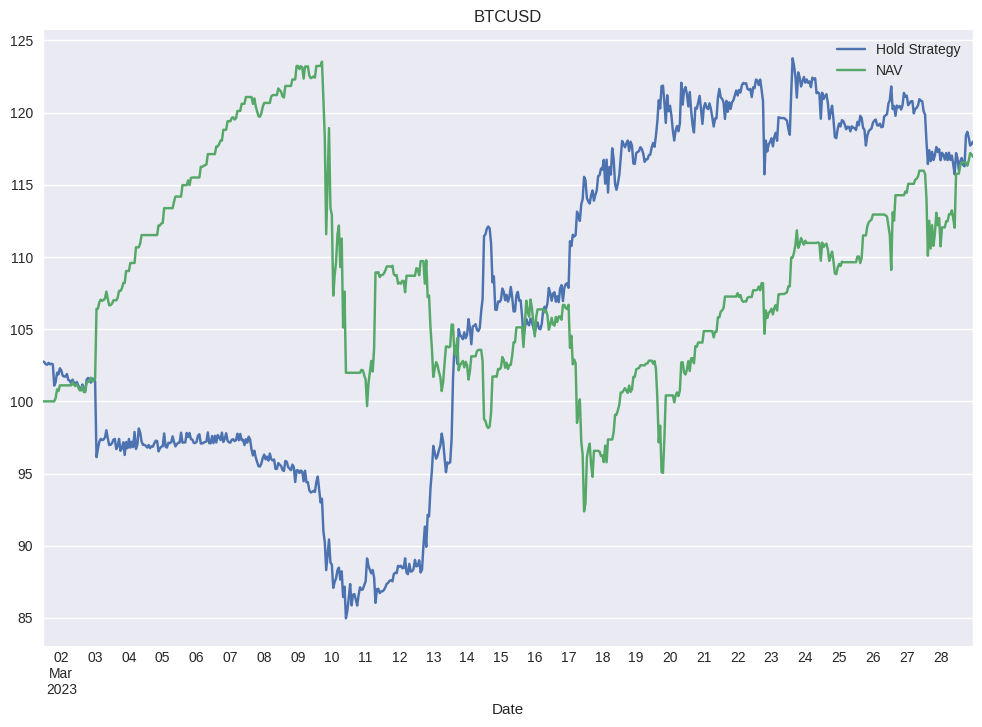

In [78]:
#plot the best strategy!
bc.plot_data(["Hold Strategy", "NAV"], show_pos = False)
#2,4,6,8,10 - 353.41
#2,4,6,8 - 353.41
#2,4,6 - 353.41
#2,4 - 356.99
#3811581.05

In [ ]:
#current trader
#trader.start_trading(num_candles = 1000, interval = "5m", initial_lev = 4,
#                     initial_amount = 10, use_prc = True,
#                     devs = [1, 2], periods = [12*24*1],
#                    min_std_size = 1, min_std_use_prc= True)

In [15]:
bc.data

,Open,High,Low,Close,Volume,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,returns,...,Close|BBs|1|288|Upper,Close|BBs|1|288|Distance,Close|BBs|2|288|Lower,Close|BBs|2|288|Upper,Close|BBs|2|288|Distance,Close|BBs|4|288|Lower,Close|BBs|4|288|Upper,Close|BBs|4|288|Distance,Position,NAV
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-13 15:35:00,19198.6,19267.5,18960.0,18971.0,528.243,1.011528e+07,250,278.184,5.348447e+06,-0.011926,...,18962.142295,214.929167,18343.927911,19168.213756,214.929167,17931.784988,19580.356679,214.929167,-1,25.102222
2023-01-13 15:40:00,19142.8,19247.3,18961.0,19228.7,1638.730,3.144590e+07,236,1284.771,2.469318e+07,0.013492,...,18964.172633,468.669097,18351.747443,19168.314362,468.669097,17943.463984,19576.597822,468.669097,-1,24.766181
2023-01-13 15:45:00,19228.7,19300.0,19052.3,19250.0,1329.103,2.557445e+07,251,1071.114,2.063206e+07,0.001107,...,18966.465361,485.982639,18359.121361,19168.913362,485.982639,17954.225360,19573.809362,485.982639,-1,24.723287
2023-01-13 15:50:00,19250.0,19250.0,19052.3,19224.7,393.273,7.522620e+06,145,138.899,2.669909e+06,-0.001315,...,18968.386351,456.790972,18366.954381,19168.863675,456.790972,17965.999734,19569.818321,456.790972,-1,24.774236
2023-01-13 15:55:00,19225.0,19225.0,19052.3,19100.5,461.553,8.838105e+06,116,198.848,3.822847e+06,-0.006481,...,18968.965710,329.147569,18376.125872,19166.578989,329.147569,17980.899313,19561.805548,329.147569,-1,25.024352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-16 02:35:00,21285.1,21295.8,21251.7,21268.5,1090.157,2.319031e+07,116,471.717,1.003456e+07,-0.000841,...,21016.973569,459.615278,20392.707028,21225.062417,459.615278,19976.529333,21641.240111,459.615278,-1,21.824815
2023-01-16 02:40:00,21271.2,21282.5,21251.7,21282.5,1179.123,2.507823e+07,149,620.363,1.319561e+07,0.000658,...,21018.972528,471.636111,20394.646611,21227.081167,471.636111,19978.429333,21643.298444,471.636111,-1,21.782428
2023-01-16 02:45:00,21281.2,21281.2,21175.0,21222.0,722.229,1.533586e+07,140,316.103,6.710593e+06,-0.002847,...,21020.771240,409.355208,20396.391896,21228.897688,409.355208,19980.139000,21645.150583,409.355208,-1,21.965601


In [9]:
#con weights default da -14.84%
#10.97
#-5.81, [ 0.31328324, 0.13459466, 0.99699542, 0.28536573, 0.66910307, 0.16991423, 0.1952118 ]
#5.44, [ 0.06402599, 0.05398925, 0.09682111, 0.04712657, 0.68254456, 0.29627987, 0.01623222 ]
#4.16, [0.25046516, 0.01399989, 0.71588332, 0.14803409, 0.68670389, 0.15511717, 0.1301157 , 0.17551095]
#-1.55, [0.38622348, 0.27510436, 0.91285762, 0.06384848, 0.79780852, 0.00582492, 0.49821469, 0.2049848 , 0.28122395, 0.10758905]
#-0.49, [0.05201524, 0.09468704, 0.38609052, 0.34201563, 0.40169521, 0.22193053, 0.47338638, 0.18096822, 0.1060569 , 0.01509651]
#1.51, [6.48569358e-02, 2.13687846e-01, 2.48874009e-01, 4.61231031e-02, 5.93058080e-01, 1.33240974e-01, 1.76164752e-04, 9.71044578e-02, 7.98704749e-02, 2.73725603e-01]
bc.optimize_parameters(number_of_tests = 1000)

---------------------------------------------------------------------------
Testing strategy | BTCUSD
---------------------------------------------------------------------------
2022-12-08 |  Buying 0.10558614630943598 for 17248.3, leverage 1
2022-12-08 |  Selling (closing) 0.10558614630943598 for 17244.8
2022-12-08 |  Selling 0.3162680999165841 for 17244.8, leverage 3
2022-12-08 |  Buying (closing) 0.3162680999165841 for 17206.8
2022-12-08 |  Buying 0.21223956454818133 for 17206.8, leverage 2
2022-12-08 |  Selling (closing) 0.21223956454818133 for 17189.5
2022-12-08 |  Selling 0.10590489658333911 for 17189.5, leverage 1
2022-12-08 |  Buying (closing) 0.10590489658333911 for 17174.3
2022-12-08 |  Buying 0.31776710683480336 for 17174.3, leverage 3
2022-12-08 |  Selling (closing) 0.31776710683480336 for 17210.4
2022-12-08 |  Selling 0.21226816840889626 for 17210.4, leverage 2
2022-12-08 |  Buying (closing) 0.21226816840889626 for 17198.1
2022-12-08 |  Buying 0.1062351903754964 for 17198.

(array([0.15783727, 0.07522492, 0.37291302, 0.26759086, 0.25177262,
        0.0432453 , 0.53977289, 0.07360026, 0.03272391, 0.07004002]),
 1908.4)

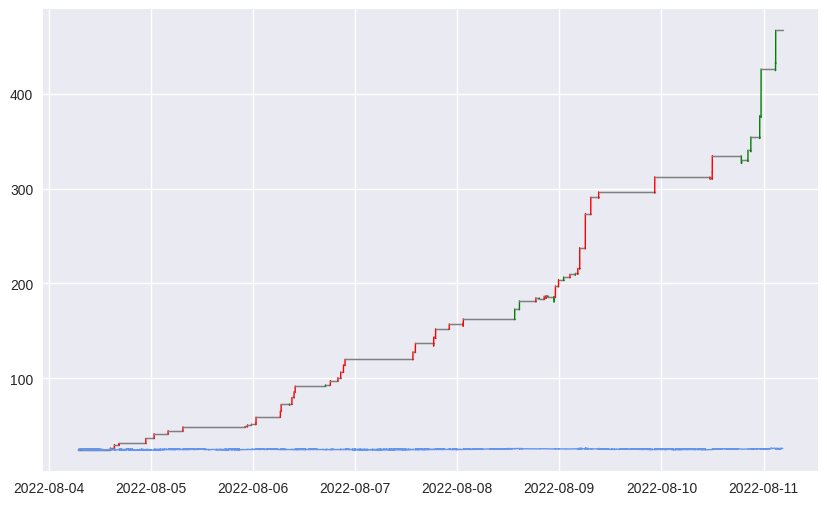

In [68]:
bc.plot_data(["Hold Strategy", "NAV"], show_pos = True)

## Optimizer2

In [8]:
bc = IterativeBacktest(
    symbol = "BTCUSD", 
    #start of file at 2022-12-01 09:02
    #end of file at 2022-12-08 07:41
    start = "2022-12-01 09:02", 
    end = "2022-12-01 21:02", #take care of the length of period!! It will help to make tests faster
    amount = 25, #Less amount means make tests faster
    use_fee= True,
    fee_maker = 0.0002,
    fee_taker = 0.0004,
    csv = "data/btc-usdt_dic_1m.csv"
)

<AxesSubplot:xlabel='Date'>

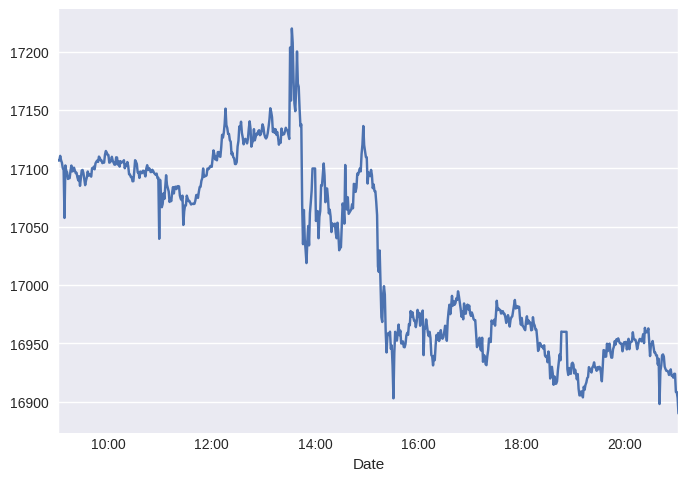

In [7]:
bc.data["2022-12-01 09:02":"2022-12-01 21:02"].Close.plot()

Best with neutral condition
[0.478770334468231,
  0.0031560527536544955,
  -0.5192054850787833,
  0.10292909358511802,
  -0.4492439944500403,
  -0.6029719217864418,
  -0.3884088933801414,
  -0.538594842211182,
  0.788843905984422,
  0.20585613758830898]

In [6]:
bc = IterativeBacktest(
    symbol = "BTCUSD", 
    #start of file at 2022-12-07 22:18
    #end of file at 2022-12-09 07:37
    start = "2022-12-08 18:50", 
    end = "2023-12-09 07:36", #take care of the length of period!! It will help to make tests faster
    amount = 25, #Less amount means make tests faster
    use_fee= True,
    fee_maker = 0.0002,
    fee_taker = 0.0004,
    csv = "data/btc-usdt_last_1m.csv"
)

<AxesSubplot:xlabel='Date'>

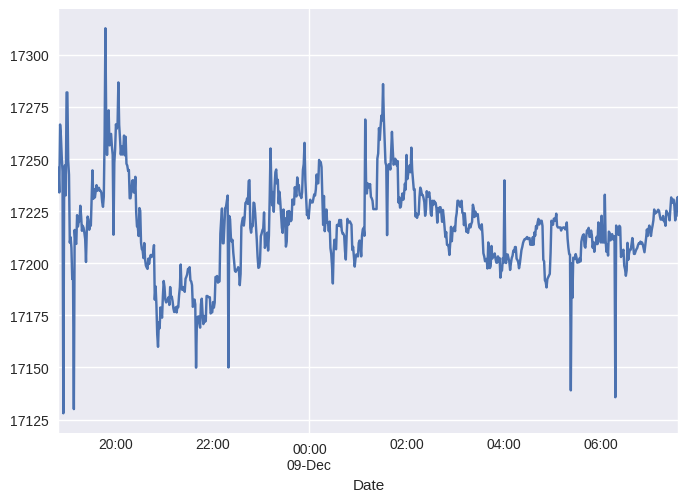

In [29]:
bc.data["2022-12-08 18:50":"2022-12-09 07:36"].Close.plot()

Best (old)
[0.058913730275212295,
  0.11567860336002611,
  0.9225715022449273,
  0.12906287377140657,
  0.7649939222524714,
  0.09716169811372732,
  0.2423478585867047,
  0.29830074099921056,
  0.12317946940774416,
  0.17615290544923612]
  
  Best with neutral condition
[0.08877842031603478,
  0.05987706928852676,
  0.13120415318448939,
  0.023081971180099897,
  1.2296684936304951,
  0.05058368745150239,
  0.027529078706913866,
  0.017268540027698426,
  0.12069770802559819,
  0.08091687035480966]

In [ ]:
bc = IterativeBacktest(
    symbol = "BTCUSD", 
    #start of file at 2022-08-04 05:50
    #end of file at 2022-08-11 04:30
    start = "2022-08-04 05:50",
    end = "2022-08-04 17:50",
    amount = 25, #Less amount means make tests faster
    use_fee= True,
    fee_maker = 0.0002,
    fee_taker = 0.0004,
    #csv = "data/btc-usdt_last_1m.csv"
    csv = "data/out.csv"
)

In [ ]:
bc.data["2022-08-04 05:50":"2022-08-04 17:50"].Close.plot()

Best (old)
[0.058166535209210446,
  0.9700926473882029,
  0.9627425158460806,
  0.3583538477903666,
  0.5028761965612344,
  0.1155499443699074,
  0.05058181494685321,
  0.13653603154728544,
  0.12317946940774416,
  0.5472318175361094]

In [8]:
bc = IterativeBacktest(
    symbol = "BTCUSD", 
    #start of file at 2022-12-14 09:32
    #end of file at 2022-12-14 21:31
    start = "2022-12-14 09:32",
    end = "2022-12-14 21:31",
    amount = 25, #Less amount means make tests faster
    use_fee= True,
    fee_maker = 0.0002,
    fee_taker = 0.0004,
    #csv = "data/btc-usdt_last_1m.csv"
    csv = "data/dic14_1m.csv"
)

<AxesSubplot:xlabel='Date'>

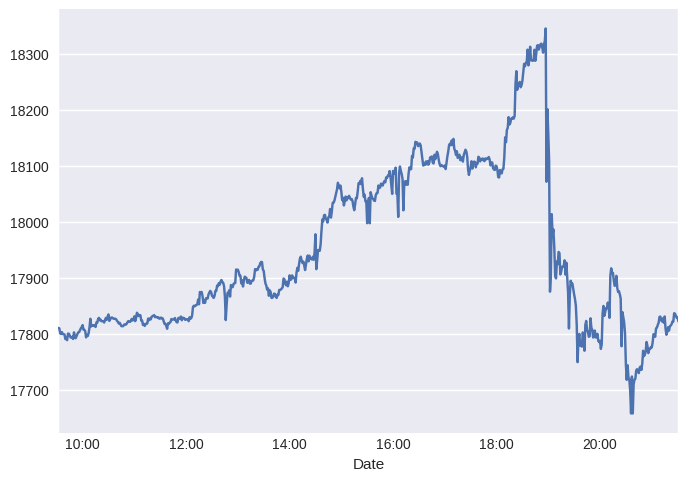

In [7]:
bc.data["2022-12-14 09:32":"2022-12-14 21:31"].Close.plot()

Best with neutral condition
[0.7871557383091642,
  -0.8657761095860563,
  0.3734549062758434,
  0.12276888923068577,
  0.7422791624237397,
  -0.14348310827135344,
  -0.06925493650665908,
  -0.8855143899864638,
  1.2969538054514855,
  0.33845213101763416]

In [ ]:
bc.optimize_parameters2(dropout = 3, iterations = 300,
                        initial_weights = None)

Initial weights
[ 0.9222819  -0.78467395 -0.91489447  0.88701228 -0.68358178  0.72178732
  0.63920656  0.4391517  -0.45469019 -0.42408752]
-38.04%
Found better...
[0.9855445858938051, -0.32700032891503084, -0.9776504231675386, 0.9478556991469826, -0.7304711543194305, -0.479463971807913, 0.6830520740431069, 0.46927471945200944, -0.4858790556748246, 0.9413279107832373]
-27.08%
Found better...
[0.9855445858938051, 0.4866880216666416, -0.9776504231675386, 0.9478556991469826, -0.7036061252779018, 0.09604697922719674, 0.6830520740431069, 0.46927471945200944, -0.4858790556748246, 0.9413279107832373]
-24.92%
Found better...
[0.9855445858938051, 0.4866880216666416, 0.6333945098932994, 0.9478556991469826, -0.7036061252779018, 0.31079061221447923, 0.6830520740431069, -0.8866371290346742, -0.4858790556748246, 0.9413279107832373]
-18.32%
Found better...
[0.9855445858938051, 0.4866880216666416, 0.6333945098932994, 0.9478556991469826, -0.7036061252779018, 0.884754422163613, -0.273894323529039, -0.546

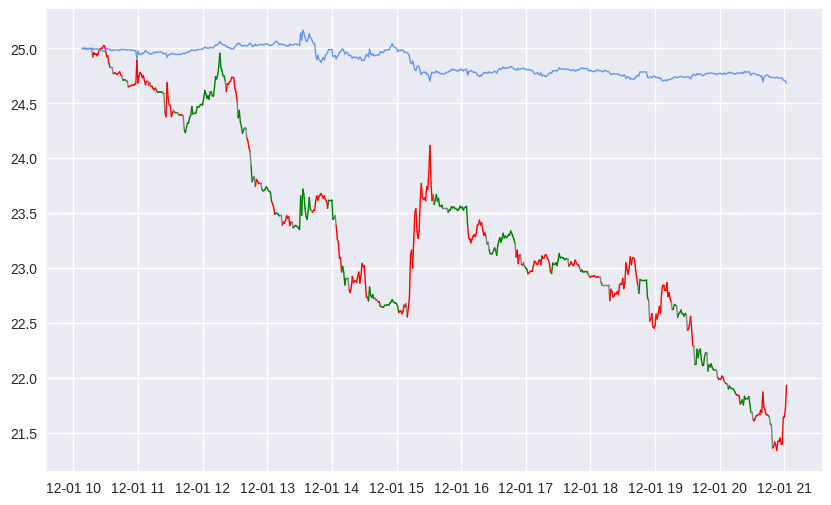

In [9]:
bc.plot_data(["Hold Strategy", "NAV"], show_pos = True)

In [9]:
bc.optimize_parameters2(dropout = 3, iterations = 1000,
                        initial_weights = None)

Initial weights
[ 0.33070119  0.34359794  0.97084284 -0.25493651  0.88541426 -0.93597815
  0.09309272 -0.44965942 -0.15065185  0.12752097]
-29.0%
Found better...
[0.3003080465765301, 0.3120195216137797, 0.8816173927009056, -0.23150653606027294, 0.8040401306936646, -0.8499569468542406, 0.08453701795257777, -0.4083334071433554, -0.13680617358511138, 0.11580113559100552]
-28.56%
Found better...
[0.3003080465765301, -0.28783433181225204, 0.8816173927009056, -0.5295521091274509, 0.8040401306936646, -0.8499569468542406, 0.08453701795257777, -0.4083334071433554, -0.13680617358511138, 0.8703357439654495]
-27.56%
Found better...
[0.3098455563915849, -0.2969756878167423, 0.9096167574594023, -0.5463702014029069, 0.8295757123259554, -0.8769508047125597, 0.08722183658347885, -0.42130170394006494, -0.1411510129532286, 0.8979768138438357]
-25.44%
Found better...
[0.7985380150723413, -0.2969756878167423, -0.9047143751851925, -0.5463702014029069, 0.8295757123259554, -0.8769508047125597, -0.712681505259

2022-12-14 |  Selling (closing) 0.0063665767388707065 for 17855.6
2022-12-14 |  Buying 0.002550842362402864 for 17863.6, leverage 2
2022-12-14 |  Selling (closing) 0.002550842362402864 for 17867.0
2022-12-14 |  Selling 0.0012742116191922022 for 17867.0, leverage 1
2022-12-14 |  Buying (closing) 0.0012742116191922022 for 17887.4
2022-12-14 |  Buying 0.002539808641316155 for 17887.4, leverage 2
2022-12-14 |  Selling (closing) 0.002539808641316155 for 17910.5
2022-12-14 |  Selling 0.0038082483883123495 for 17903.8, leverage 3
2022-12-14 |  Buying (closing) 0.0038082483883123495 for 17895.7
2022-12-14 |  Buying 0.002538481146494669 for 17895.7, leverage 2
2022-12-14 |  Selling (closing) 0.002538481146494669 for 17884.7
2022-12-14 |  Selling 0.016393866087008557 for 17884.7, leverage 13
2022-12-14 |  Buying (closing) 0.016393866087008557 for 17913.4
2022-12-14 |  Buying 0.014668132697237872 for 17913.4, leverage 12
2022-12-14 |  Selling (closing) 0.014668132697237872 for 17890.3
2022-12-14 

([0.7871557383091642,
  -0.8657761095860563,
  0.3734549062758434,
  0.12276888923068577,
  0.7422791624237397,
  -0.14348310827135344,
  -0.06925493650665908,
  -0.8855143899864638,
  1.2969538054514855,
  0.33845213101763416],
 26.06)

In [146]:
loc = 1
scale = 0.15
s = np.random.normal(loc = loc, scale = scale, size = 1000)

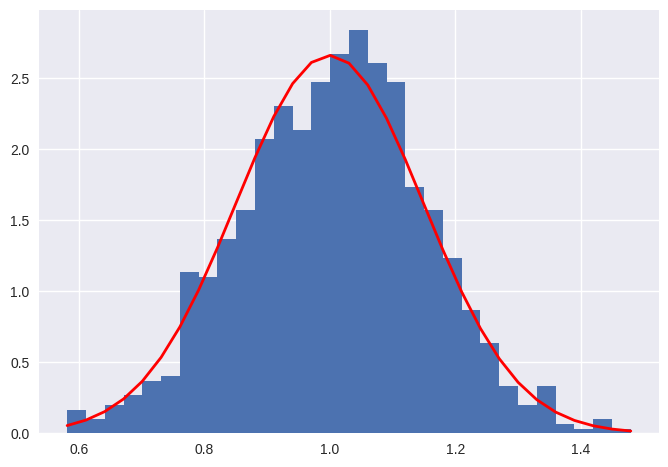

In [147]:
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(scale * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - loc)**2 / (2 * scale**2) ),
         linewidth=2, color='r')
plt.show()

Using
w = [0.08877842031603478,
  0.05987706928852676,
  0.13120415318448939,
  0.023081971180099897,
  1.2296684936304951,
  0.05058368745150239,
  0.027529078706913866,
  0.017268540027698426,
  0.12069770802559819,
  0.08091687035480966]

In [55]:
np.random.uniform(low=0.5, high=0.5)

0.5

In [171]:
bc.data

,Open,High,Low,Close,Volume,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,returns,Hold Strategy,Close|SMA|576,Close|BBs|2|576|Lower,Close|BBs|2|576|Upper,Close|BBs|2|576|Distance,Position,NAV
Date,,,,,,,,,,,,,,,,,
2022-01-10 20:05:00,41304.8,41319.0,40900.0,41286.4,999.606,4.123233e+07,229,453.270,1.870056e+07,-0.000617,101.257801,41712.873056,40219.734963,43206.011148,-426.473056,0,100.000000
2022-01-10 20:10:00,41290.9,41454.8,41212.0,41267.9,1455.985,6.016094e+07,215,480.085,1.983939e+07,-0.000448,101.212428,41713.731302,40222.189188,43205.273416,-445.831302,0,100.000000
2022-01-10 20:15:00,41242.5,41398.3,41186.3,41347.7,1209.593,4.995658e+07,157,678.680,2.803260e+07,0.001932,101.408143,41714.652326,40224.674155,43204.630497,-366.952326,0,100.000000
2022-01-10 20:20:00,41341.0,41391.3,41282.4,41341.2,1358.443,5.615266e+07,157,762.224,3.150424e+07,-0.000157,101.392202,41715.495174,40226.915304,43204.075044,-374.295174,0,100.000000
2022-01-10 20:25:00,41338.8,41433.8,41323.3,41386.2,1096.478,4.537057e+07,119,689.604,2.853695e+07,0.001088,101.502567,41716.125955,40228.414451,43203.837459,-329.925955,0,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-22 01:10:00,16841.0,16856.4,16840.0,16845.1,386.166,6.505263e+06,62,235.317,3.964590e+06,-0.000154,41.313793,16818.088368,16481.726601,17154.450135,27.011632,0,5.449632
2022-12-22 01:15:00,16847.5,16849.7,16834.7,16834.7,340.617,5.736202e+06,68,133.100,2.241819e+06,-0.000618,41.288286,16818.678125,16482.304562,17155.051687,16.021875,0,5.449632
2022-12-22 01:20:00,16835.9,16844.6,16829.3,16842.9,406.593,6.847326e+06,75,177.577,2.990526e+06,0.000487,41.308397,16819.297743,16482.911788,17155.683698,23.602257,0,5.449632


In [187]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
last_n = 5
x = np.array(range(last_n)).reshape(-1, 1)
y = bc.data["Close|SMA|576"][-last_n:].values.reshape(-1,1)
regressor.fit(x, y)

LinearRegression()

array([[    0],
       [    1],
       [    2],
       ...,
       [99423],
       [99424],
       [99425]])

In [195]:
m = regressor.coef_.reshape(-1)[]
m

array([0.57982639])

In [189]:
bc.data["Close|SMA|576"][-5:]

Date
2022-12-22 01:10:00    16818.088368
2022-12-22 01:15:00    16818.678125
2022-12-22 01:20:00    16819.297743
2022-12-22 01:25:00    16819.893056
2022-12-22 01:30:00    16820.380035
Name: Close|SMA|576, dtype: float64

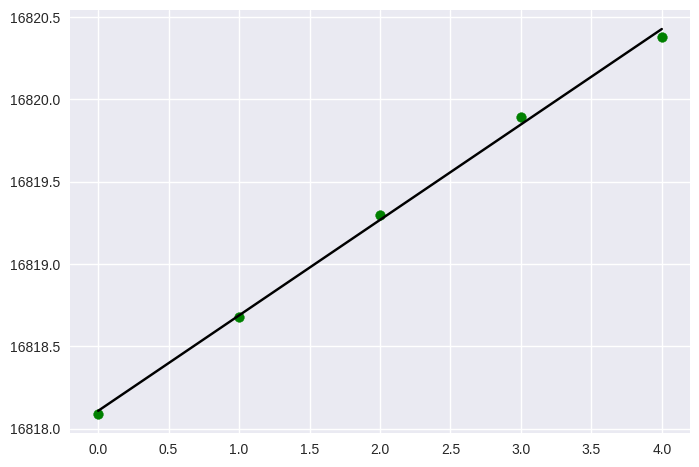

In [191]:
plt.scatter(x, y,color='g') 
plt.plot(x, regressor.predict(x),color='k') 

In [196]:
regressor.intercept_

array([16818.1078125])

# Test alcista

In [7]:
bc = IterativeBacktest(
    symbol = "BTCUSD", 
    start = "2023-10-01", 
    end = "2023-11-19", #take care of the length of period!! It will help to make tests faster
    #start = "2023-02-08", 
    #end = "2023-03-01", #take care of the length of period!! It will help to make tests faster 
    amount = 150, #Less amount means make tests faster
    use_fee= True,
    fee_maker = 0.0004,
    fee_taker = 0.0004,
    csv = "data/2023-2023nov20.csv"
)

In [12]:
bc.test_rnn_strategy(keep_metrics = True, verbose = True, leverage = 5, amount_prc=10, wait_interval = 24)

---------------------------------------------------------------------------
Testing strategy | BTCUSD
---------------------------------------------------------------------------


/home/mauricio/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


2023-10-08 00:00:00 |  Selling 0.002 for 27946.2, leverage 5
2023-10-08 04:00:00 |  Buying (closing) 0.002 for 27929.5
2023-10-09 05:00:00 |  Buying 0.002 for 27866.0, leverage 5
2023-10-09 17:00:00 |  Selling (closing) 0.002 for 27570.1
2023-10-10 18:00:00 |  Selling 0.002 for 27637.8, leverage 5
2023-10-10 23:00:00 |  Buying (closing) 0.002 for 27451.5
2023-10-10 23:00:00 |  Buying 0.002 for 27451.5, leverage 5
2023-10-11 01:00:00 |  Selling (closing) 0.002 for 27649.0
2023-10-11 01:00:00 |  Selling 0.002 for 27649.0, leverage 5
2023-10-11 02:00:00 |  Buying (closing) 0.002 for 27505.0
2023-10-11 02:00:00 |  Buying 0.002 for 27505.0, leverage 5
2023-10-11 07:00:00 |  Selling (closing) 0.002 for 27466.0
2023-10-12 08:00:00 |  Buying 0.002 for 26815.9, leverage 5
2023-10-12 09:00:00 |  Selling (closing) 0.002 for 26945.3
2023-10-12 09:00:00 |  Selling 0.002 for 26945.3, leverage 5
2023-10-12 10:00:00 |  Buying (closing) 0.002 for 26757.7
2023-10-12 10:00:00 |  Buying 0.002 for 26757.7,

2023-11-03 12:00:00 |  Selling (closing) 0.002 for 34394.3
2023-11-04 13:00:00 |  Buying 0.002 for 34702.6, leverage 5
2023-11-04 17:00:00 |  Selling (closing) 0.002 for 34769.6
2023-11-04 17:00:00 |  Selling 0.002 for 34769.6, leverage 5
2023-11-04 20:00:00 |  Buying (closing) 0.002 for 34746.6
2023-11-05 21:00:00 |  Buying 0.002 for 34650.3, leverage 5
2023-11-05 22:00:00 |  Selling (closing) 0.002 for 34987.6
2023-11-05 22:00:00 |  Selling 0.002 for 34987.6, leverage 5
2023-11-06 01:00:00 |  Buying (closing) 0.002 for 34887.1
2023-11-06 01:00:00 |  Buying 0.002 for 34887.1, leverage 5
2023-11-06 03:00:00 |  Selling (closing) 0.002 for 34976.0
2023-11-06 03:00:00 |  Selling 0.002 for 34976.0, leverage 5
2023-11-06 04:00:00 |  Buying (closing) 0.002 for 34875.5
2023-11-06 04:00:00 |  Buying 0.002 for 34875.5, leverage 5
2023-11-06 07:00:00 |  Selling (closing) 0.002 for 34903.5
2023-11-06 07:00:00 |  Selling 0.002 for 34903.5, leverage 5
2023-11-06 13:00:00 |  Buying (closing) 0.002 f

149.3

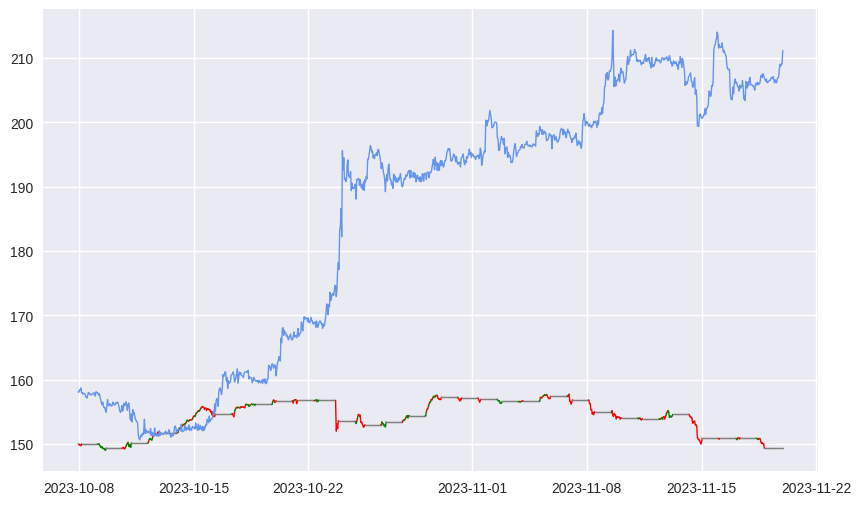

In [15]:
bc.plot_data(["Hold Strategy", "NAV"], show_pos = True)

In [228]:
bc.test_rnn_strategy(keep_metrics = True, verbose = True, leverage = 5, amount_prc=25, wait_interval = 24)

---------------------------------------------------------------------------
Testing strategy | BTCUSD
---------------------------------------------------------------------------


/home/mauricio/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [ ]:
bc.plot_data(["Hold Strategy", "NAV"], show_pos = True)

In [21]:
bc.data["rnn"].shift(1)

Date
2023-04-16 23:00:00             NaN
2023-04-17 00:00:00    30103.743602
2023-04-17 01:00:00    30113.543286
2023-04-17 02:00:00    30102.074515
2023-04-17 03:00:00    30078.514099
                           ...     
2023-06-01 19:00:00    27018.637704
2023-06-01 20:00:00    27085.464004
2023-06-01 21:00:00    27171.347562
2023-06-01 22:00:00    27082.961957
2023-06-01 23:00:00    27070.301809
Name: rnn, Length: 1105, dtype: float64

<AxesSubplot:xlabel='Date'>

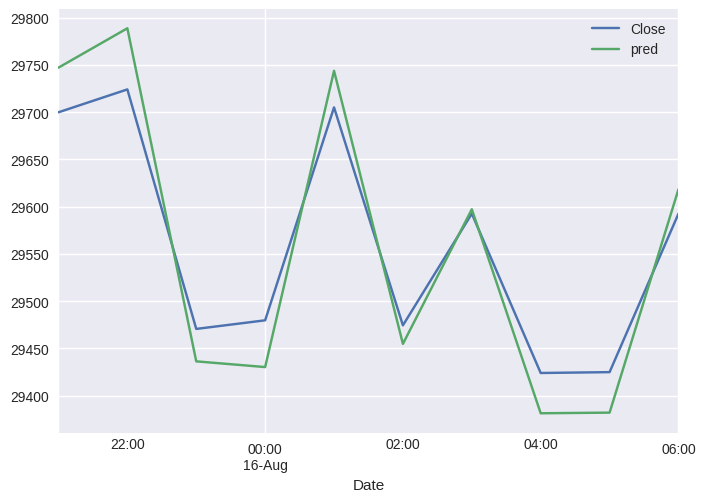

In [23]:
diff = bc.data["Close"] - bc.data["rnn"].shift(1)
pred = bc.data["rnn"] + diff
bc.data["pred"] = pred
bc.data[["Close", "pred"]][190:200].plot()

In [ ]:
strategies = [
    SMA(
        data = self.data,
        SMA_S = SMA_S,
        SMA_L = SMA_L,
        column = "Close",
        default_strategy = 1,
        weight = 1
    ),
    EWMA(
        data = self.data,
        approx_avg_period_s = approx_avg_period_s,
        approx_avg_period_l = approx_avg_period_l,
        column = "Close",
        default_strategy = 1,
        weight = 1
    ),
    BollingerBands(
        data = self.data,
        dev = dev, 
        periods = periods,
        column = "Close",
        default_strategy = 1,
        weight = 1
    ),
]

## SMA

In [215]:
SMA_S = 12
SMA_L = 48
strategies = [
    SMA(
        data = bc.data,
        SMA_S = SMA_S,
        SMA_L = SMA_L,
        column = "Close",
        default_strategy = 1,
        weight = 1
    ),
]

In [216]:
bc.test_strategy(keep_metrics = True, verbose = True, leverage = 1, amount_prc=100, strategies = strategies)

---------------------------------------------------------------------------
Testing strategy | BTCUSD
---------------------------------------------------------------------------
2023-01-07 00:00:00 |  Buying 0.002 for 16970.0, leverage 1
2023-01-18 18:00:00 |  Selling (closing) 0.002 for 20937.2
2023-01-18 18:00:00 |  Selling 0.002 for 20937.2, leverage 1
2023-01-20 03:00:00 |  Buying (closing) 0.002 for 21083.4
2023-01-20 03:00:00 |  Buying 0.002 for 21083.4, leverage 1
2023-01-23 01:00:00 |  Selling (closing) 0.002 for 22700.9
2023-01-23 01:00:00 |  Selling 0.002 for 22700.9, leverage 1
2023-01-23 18:00:00 |  Buying (closing) 0.002 for 22926.6
2023-01-23 18:00:00 |  Buying 0.002 for 22926.6, leverage 1
2023-01-25 01:00:00 |  Selling (closing) 0.002 for 22494.2
2023-01-25 01:00:00 |  Selling 0.002 for 22494.2, leverage 1
2023-01-26 02:00:00 |  Buying (closing) 0.002 for 23172.0
2023-01-26 02:00:00 |  Buying 0.002 for 23172.0, leverage 1
2023-01-27 09:00:00 |  Selling (closing) 0.002 f

64.38

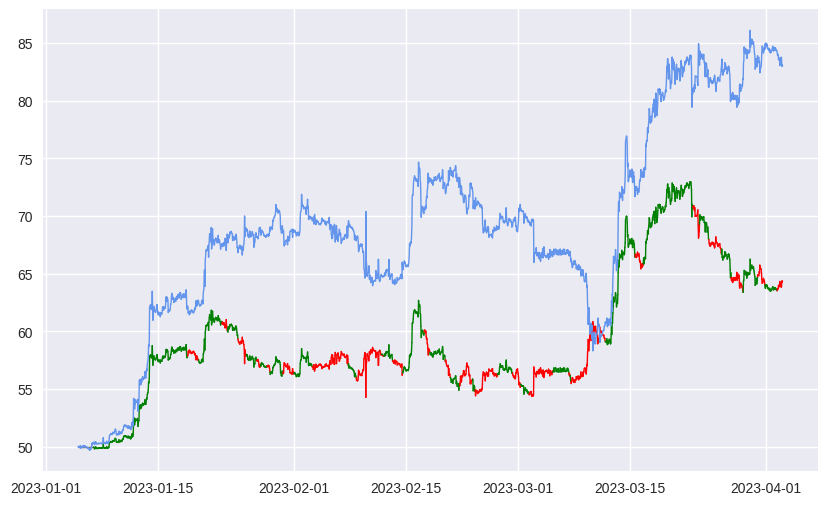

In [217]:
bc.plot_data(["Hold Strategy", "NAV"], show_pos = True)

## BOLLINGER BANDS

In [218]:
dev = 2
periods = 8

strategies = [
    BollingerBands(
        data = bc.data,
        dev = dev, 
        periods = periods,
        column = "Close",
        default_strategy = 1,
        weight = 1
    ),
]

In [219]:
bc.test_strategy(keep_metrics = True, verbose = True, leverage = 2, amount_prc=100, strategies = strategies)

---------------------------------------------------------------------------
Testing strategy | BTCUSD
---------------------------------------------------------------------------
2023-01-05 08:00:00 |  Selling 0.005 for 16869.9, leverage 2
2023-01-12 13:00:00 |  Buying (closing) 0.005 for 17870.0
2023-01-12 13:00:00 |  Buying 0.005 for 17870.0, leverage 2
2023-01-12 17:00:00 |  Selling (closing) 0.005 for 18768.4
2023-01-12 17:00:00 |  Selling 0.005 for 18768.4, leverage 2
2023-01-16 08:00:00 |  Buying (closing) 0.005 for 20746.4
2023-01-16 08:00:00 |  Buying 0.003 for 20746.4, leverage 2
2023-01-16 15:00:00 |  Selling (closing) 0.003 for 20993.1
2023-01-16 15:00:00 |  Selling 0.003 for 20993.1, leverage 2
2023-01-21 09:00:00 |  Buying (closing) 0.003 for 22361.0
2023-01-21 09:00:00 |  Buying 0.003 for 22361.0, leverage 2
2023-01-23 10:00:00 |  Selling (closing) 0.003 for 22910.3
2023-01-23 10:00:00 |  Selling 0.003 for 22910.3, leverage 2
2023-01-24 09:00:00 |  Buying (closing) 0.00299

53.36

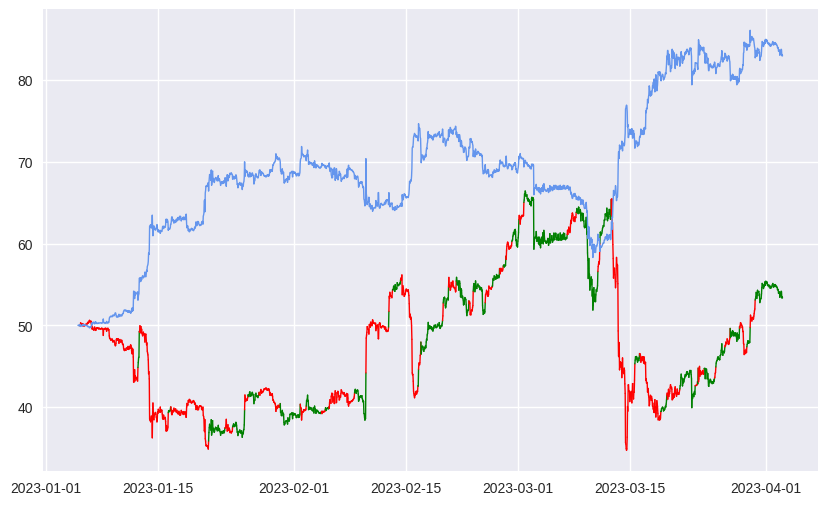

In [220]:
bc.plot_data(["Hold Strategy", "NAV"], show_pos = True)

## TEST BAJISTA

In [237]:
bc = IterativeBacktest(
    symbol = "BTCUSD", 
    start = "2023-08-01",#"2023-04-10", 
    end = "2023-09-01",#"2023-06-01", #take care of the length of period!! It will help to make tests faster 
    amount = 150, #Less amount means make tests faster
    use_fee= True,
    fee_maker = 0.0004,
    fee_taker = 0.0004,
    csv = "data/2023-oct29.csv"
)

<AxesSubplot:xlabel='Date'>

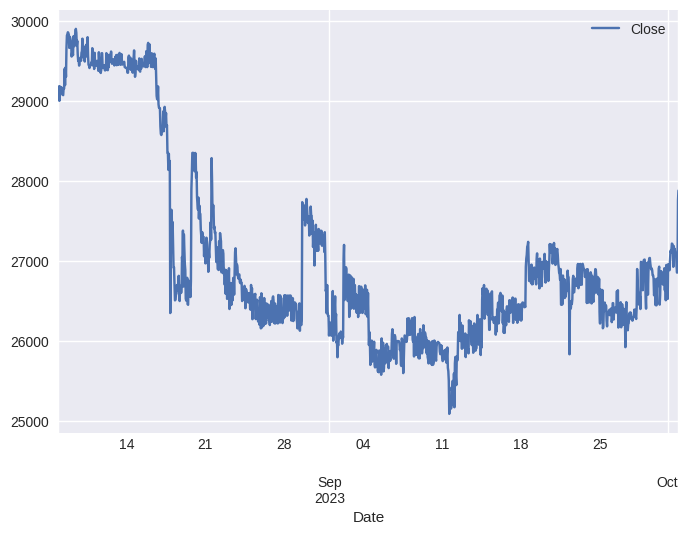

In [236]:
bc.data[["Close"]].plot()

In [241]:
bc.test_rnn_strategy(keep_metrics = True, verbose = True, leverage = 5, amount_prc=25, wait_interval = 0)

---------------------------------------------------------------------------
Testing strategy | BTCUSD
---------------------------------------------------------------------------


/home/mauricio/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


2023-08-08 00:00:00 |  Selling 0.006 for 29180.0, leverage 5
2023-08-08 01:00:00 |  Buying (closing) 0.005999999999999999 for 29000.0
2023-08-08 01:00:00 |  Buying 0.006 for 29000.0, leverage 5
2023-08-08 02:00:00 |  Selling (closing) 0.006 for 29180.5
2023-08-08 02:00:00 |  Selling 0.006 for 29180.5, leverage 5
2023-08-08 07:00:00 |  Buying (closing) 0.006000000000000001 for 29080.1
2023-08-08 07:00:00 |  Buying 0.006 for 29080.1, leverage 5
2023-08-08 10:00:00 |  Selling (closing) 0.005999999999999999 for 29161.3
2023-08-08 10:00:00 |  Selling 0.006 for 29161.3, leverage 5
2023-08-08 22:00:00 |  Buying (closing) 0.006 for 29661.1
2023-08-08 22:00:00 |  Buying 0.006 for 29661.1, leverage 5
2023-08-08 23:00:00 |  Selling (closing) 0.005999999999999999 for 29800.0
2023-08-08 23:00:00 |  Selling 0.006 for 29800.0, leverage 5
2023-08-09 02:00:00 |  Buying (closing) 0.006 for 29729.1
2023-08-09 02:00:00 |  Buying 0.006 for 29729.1, leverage 5
2023-08-09 07:00:00 |  Selling (closing) 0.006 

2023-08-16 19:00:00 |  Selling (closing) 0.008 for 29180.3
2023-08-16 19:00:00 |  Selling 0.008 for 29180.3, leverage 5
2023-08-16 20:00:00 |  Buying (closing) 0.008 for 28957.4
2023-08-16 20:00:00 |  Buying 0.008 for 28957.4, leverage 5
2023-08-17 05:00:00 |  Selling (closing) 0.008 for 28670.0
2023-08-17 05:00:00 |  Selling 0.008 for 28670.0, leverage 5
2023-08-17 07:00:00 |  Buying (closing) 0.008 for 28620.0
2023-08-17 07:00:00 |  Buying 0.008 for 28620.0, leverage 5
2023-08-17 08:00:00 |  Selling (closing) 0.008 for 28744.5
2023-08-17 08:00:00 |  Selling 0.008 for 28744.5, leverage 5
2023-08-17 11:00:00 |  Buying (closing) 0.008 for 28771.7
2023-08-17 11:00:00 |  Buying 0.008 for 28771.7, leverage 5
2023-08-17 12:00:00 |  Selling (closing) 0.008 for 28847.0
2023-08-17 12:00:00 |  Selling 0.008 for 28847.0, leverage 5
2023-08-17 13:00:00 |  Buying (closing) 0.008 for 28670.9
2023-08-17 13:00:00 |  Buying 0.008 for 28670.9, leverage 5
2023-08-17 23:00:00 |  Selling (closing) 0.008 f

2023-08-27 04:00:00 |  Selling (closing) 0.014000000000000002 for 26469.8
2023-08-27 04:00:00 |  Selling 0.014 for 26469.8, leverage 5
2023-08-27 05:00:00 |  Buying (closing) 0.014 for 26221.4
2023-08-27 05:00:00 |  Buying 0.015 for 26221.4, leverage 5
2023-08-27 06:00:00 |  Selling (closing) 0.015 for 26430.0
2023-08-27 06:00:00 |  Selling 0.015 for 26430.0, leverage 5
2023-08-27 10:00:00 |  Buying (closing) 0.015 for 26220.0
2023-08-27 10:00:00 |  Buying 0.015 for 26220.0, leverage 5
2023-08-27 11:00:00 |  Selling (closing) 0.014999999999999998 for 26575.9
2023-08-27 11:00:00 |  Selling 0.015 for 26575.9, leverage 5
2023-08-27 14:00:00 |  Buying (closing) 0.015 for 26233.0
2023-08-27 14:00:00 |  Buying 0.015 for 26233.0, leverage 5
2023-08-27 15:00:00 |  Selling (closing) 0.015 for 26570.5
2023-08-27 15:00:00 |  Selling 0.015 for 26570.5, leverage 5
2023-08-27 16:00:00 |  Buying (closing) 0.015 for 26235.5
2023-08-27 16:00:00 |  Buying 0.016 for 26235.5, leverage 5
2023-08-27 17:00:0

502.29

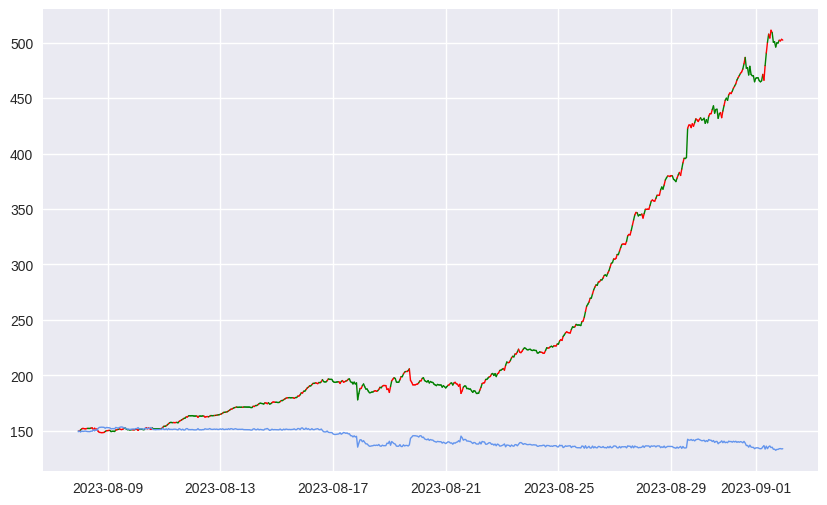

In [242]:
bc.plot_data(["Hold Strategy", "NAV"], show_pos = True)

In [239]:
bc.test_rnn_strategy(keep_metrics = True, verbose = True, leverage = 5, amount_prc=25, wait_interval = 24)

---------------------------------------------------------------------------
Testing strategy | BTCUSD
---------------------------------------------------------------------------


/home/mauricio/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


2023-08-08 00:00:00 |  Selling 0.006 for 29180.0, leverage 5
2023-08-08 01:00:00 |  Buying (closing) 0.005999999999999999 for 29000.0
2023-08-08 01:00:00 |  Buying 0.006 for 29000.0, leverage 5
2023-08-08 02:00:00 |  Selling (closing) 0.006 for 29180.5
2023-08-08 02:00:00 |  Selling 0.006 for 29180.5, leverage 5
2023-08-08 07:00:00 |  Buying (closing) 0.006000000000000001 for 29080.1
2023-08-08 07:00:00 |  Buying 0.006 for 29080.1, leverage 5
2023-08-08 10:00:00 |  Selling (closing) 0.005999999999999999 for 29161.3
2023-08-08 10:00:00 |  Selling 0.006 for 29161.3, leverage 5
2023-08-08 22:00:00 |  Buying (closing) 0.006 for 29661.1
2023-08-09 23:00:00 |  Buying 0.006 for 29500.0, leverage 5
2023-08-10 00:00:00 |  Selling (closing) 0.006 for 29600.0
2023-08-10 00:00:00 |  Selling 0.006 for 29600.0, leverage 5
2023-08-10 03:00:00 |  Buying (closing) 0.006000000000000001 for 29568.8
2023-08-10 03:00:00 |  Buying 0.006 for 29568.8, leverage 5
2023-08-10 08:00:00 |  Selling (closing) 0.006 

2023-08-24 23:00:00 |  Buying (closing) 0.01 for 26400.1
2023-08-24 23:00:00 |  Buying 0.01 for 26400.1, leverage 5
2023-08-25 01:00:00 |  Selling (closing) 0.01 for 26701.0
2023-08-25 01:00:00 |  Selling 0.01 for 26701.0, leverage 5
2023-08-25 04:00:00 |  Buying (closing) 0.01 for 26273.0
2023-08-25 04:00:00 |  Buying 0.01 for 26273.0, leverage 5
2023-08-25 06:00:00 |  Selling (closing) 0.01 for 26580.1
2023-08-25 06:00:00 |  Selling 0.01 for 26580.1, leverage 5
2023-08-25 11:00:00 |  Buying (closing) 0.01 for 26275.0
2023-08-25 11:00:00 |  Buying 0.01 for 26275.0, leverage 5
2023-08-25 14:00:00 |  Selling (closing) 0.01 for 26516.0
2023-08-25 14:00:00 |  Selling 0.01 for 26516.0, leverage 5
2023-08-25 15:00:00 |  Buying (closing) 0.01 for 26300.0
2023-08-25 15:00:00 |  Buying 0.011 for 26300.0, leverage 5
2023-08-25 20:00:00 |  Selling (closing) 0.011000000000000001 for 26548.0
2023-08-25 20:00:00 |  Selling 0.011 for 26548.0, leverage 5
2023-08-25 22:00:00 |  Buying (closing) 0.0110

325.77

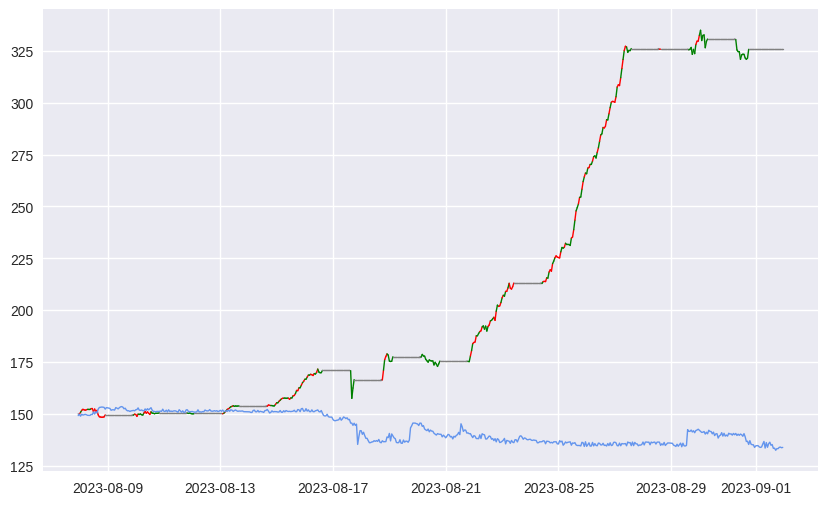

In [240]:
bc.plot_data(["Hold Strategy", "NAV"], show_pos = True)

## SMA

In [207]:
SMA_S = 12
SMA_L = 48
strategies = [
    SMA(
        data = bc.data,
        SMA_S = SMA_S,
        SMA_L = SMA_L,
        column = "Close",
        default_strategy = 1,
        weight = 1
    ),
]

In [208]:
bc.test_strategy(keep_metrics = True, verbose = True, leverage = 1, amount_prc=100, strategies = strategies)

---------------------------------------------------------------------------
Testing strategy | BTCUSD
---------------------------------------------------------------------------
2023-04-16 00:00:00 |  Selling 0.001 for 30591.2, leverage 1
2023-04-16 07:00:00 |  Buying (closing) 0.001 for 30689.0
2023-04-16 07:00:00 |  Buying 0.001 for 30689.0, leverage 1
2023-04-17 01:00:00 |  Selling (closing) 0.001 for 30307.2
2023-04-17 01:00:00 |  Selling 0.001 for 30307.2, leverage 1
2023-04-18 16:00:00 |  Buying (closing) 0.001 for 30364.3
2023-04-18 16:00:00 |  Buying 0.001 for 30364.3, leverage 1
2023-04-19 13:00:00 |  Selling (closing) 0.001 for 29618.0
2023-04-19 13:00:00 |  Selling 0.001 for 29618.0, leverage 1
2023-04-23 15:00:00 |  Buying (closing) 0.001 for 27466.4
2023-04-23 15:00:00 |  Buying 0.001 for 27466.4, leverage 1
2023-04-24 14:00:00 |  Selling (closing) 0.001 for 27419.3
2023-04-24 14:00:00 |  Selling 0.001 for 27419.3, leverage 1
2023-04-25 10:00:00 |  Buying (closing) 0.001 f

52.66

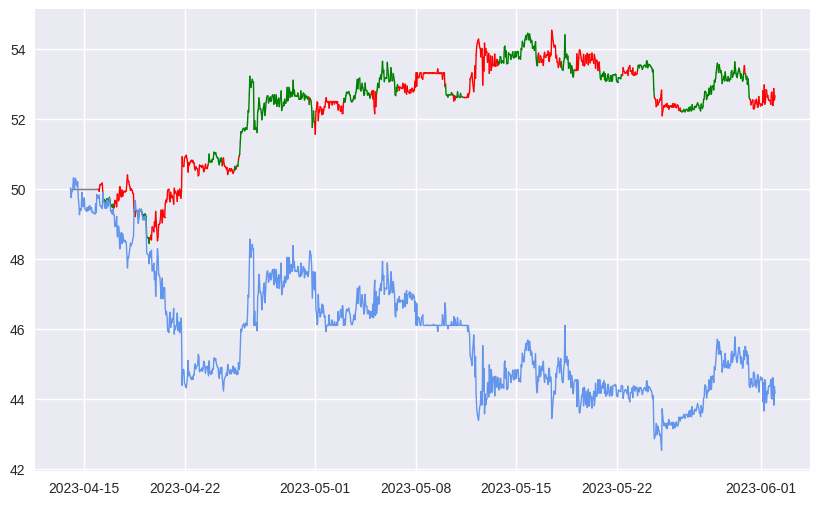

In [209]:
bc.plot_data(["Hold Strategy", "NAV"], show_pos = True)

## BBS

In [210]:
dev = 2
periods = 8

strategies = [
    BollingerBands(
        data = bc.data,
        dev = dev, 
        periods = periods,
        column = "Close",
        default_strategy = 1,
        weight = 1
    ),
]

In [212]:
bc.test_strategy(keep_metrics = True, verbose = True, leverage = 2, amount_prc=100, strategies = strategies)

---------------------------------------------------------------------------
Testing strategy | BTCUSD
---------------------------------------------------------------------------
2023-04-14 14:00:00 |  Buying 0.003 for 30599.8, leverage 2
2023-04-15 19:00:00 |  Selling (closing) 0.0029999999999999996 for 30495.0
2023-04-15 19:00:00 |  Selling 0.003 for 30495.0, leverage 2
2023-04-17 03:00:00 |  Buying (closing) 0.003 for 30087.8
2023-04-17 03:00:00 |  Buying 0.003 for 30087.8, leverage 2
2023-04-18 11:00:00 |  Selling (closing) 0.003 for 30398.3
2023-04-18 11:00:00 |  Selling 0.003 for 30398.3, leverage 2
2023-04-18 18:00:00 |  Buying (closing) 0.0029999999999999996 for 30143.1
2023-04-18 18:00:00 |  Buying 0.003 for 30143.1, leverage 2
2023-04-22 16:00:00 |  Selling (closing) 0.003 for 27632.9
2023-04-22 16:00:00 |  Selling 0.003 for 27632.9, leverage 2
2023-04-26 19:00:00 |  Buying (closing) 0.003 for 28352.0
2023-04-26 19:00:00 |  Buying 0.002 for 28352.0, leverage 2
2023-04-29 02:00

63.25

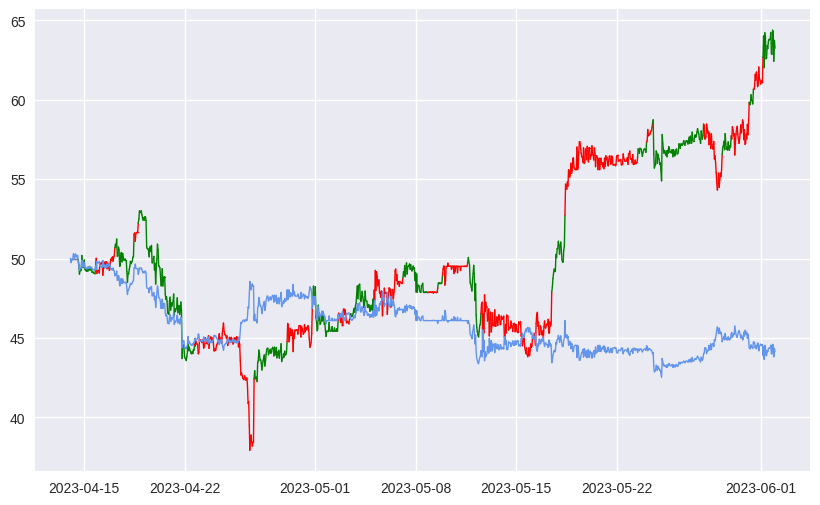

In [213]:
bc.plot_data(["Hold Strategy", "NAV"], show_pos = True)